# PRATICAL 1

# import the data

[-] Created directory: /content/drive/MyDrive/ML_at_scale/figures
[-] Loading data (this may take 1-2 minutes)...
[-] Converting timestamps...
[+] Data Loaded. 32,000,204 ratings.
[-] Generating Plot 1: Rating Distribution...


/tmp/ipython-input-3410184913.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


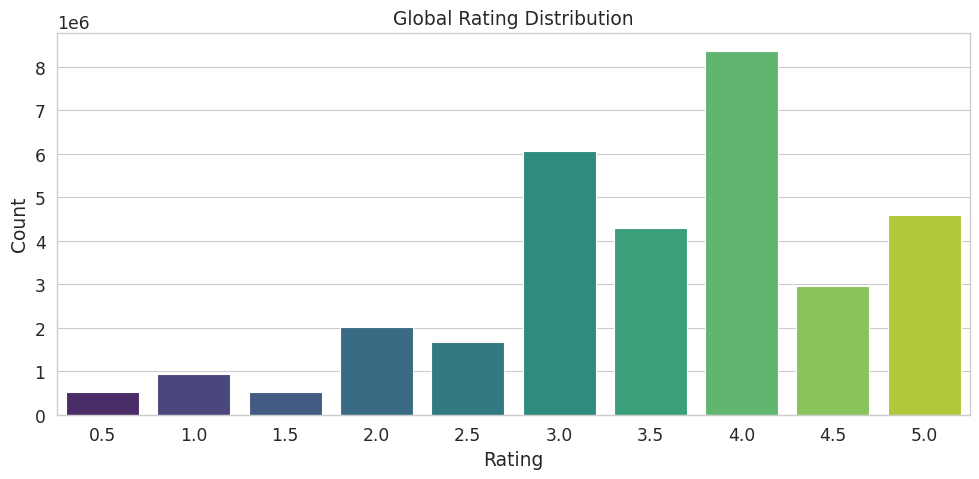

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_rating_distribution.pdf
[-] Generating Plot 2: Long Tail Distribution...


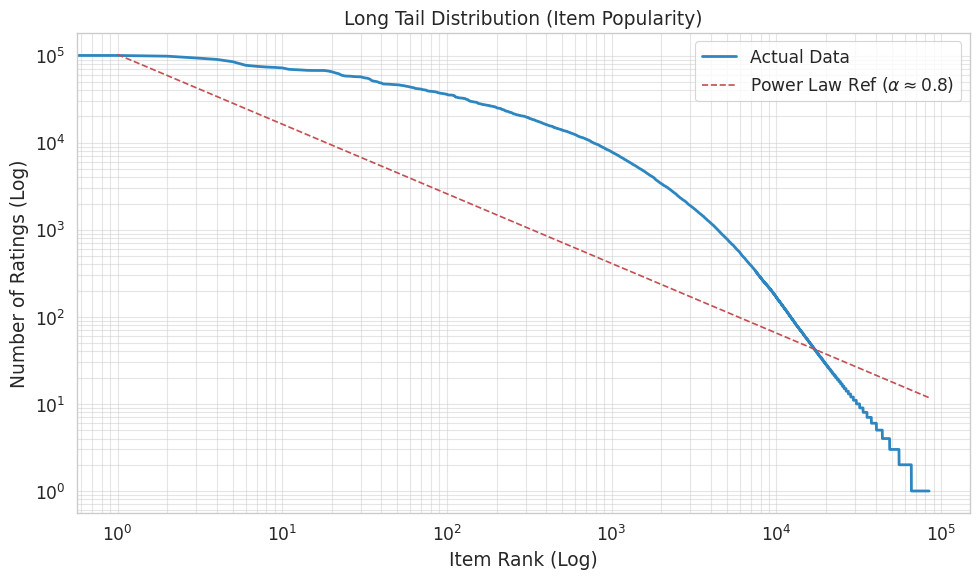

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_long_tail.pdf
[-] Generating Plot 3: Temporal Evolution...


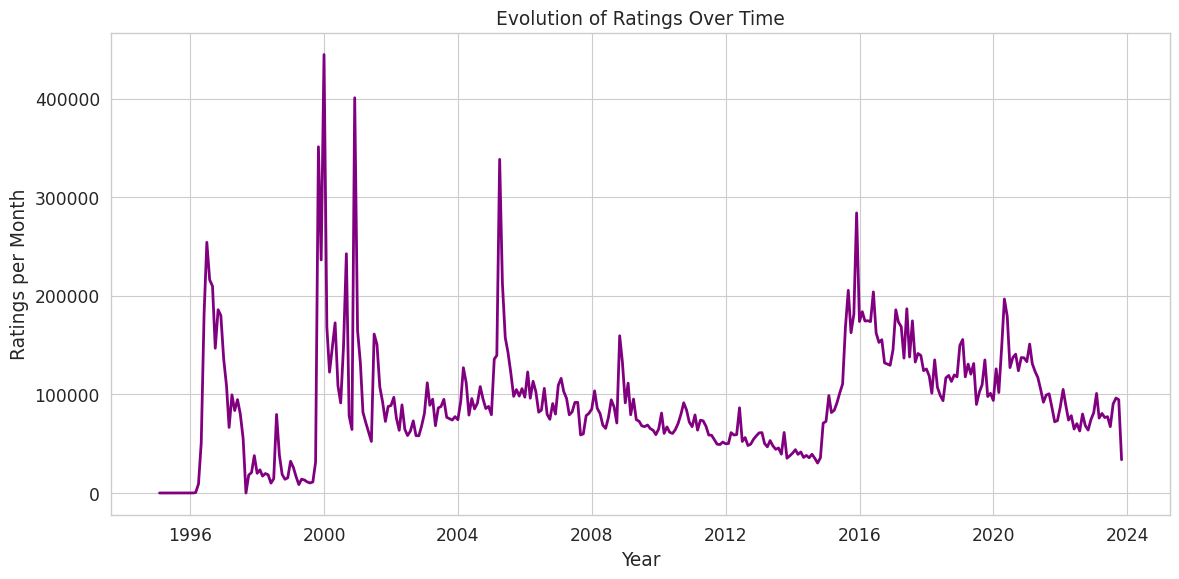

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_temporal_evolution.pdf
[-] Generating Plot 4: Interaction Heatmap...


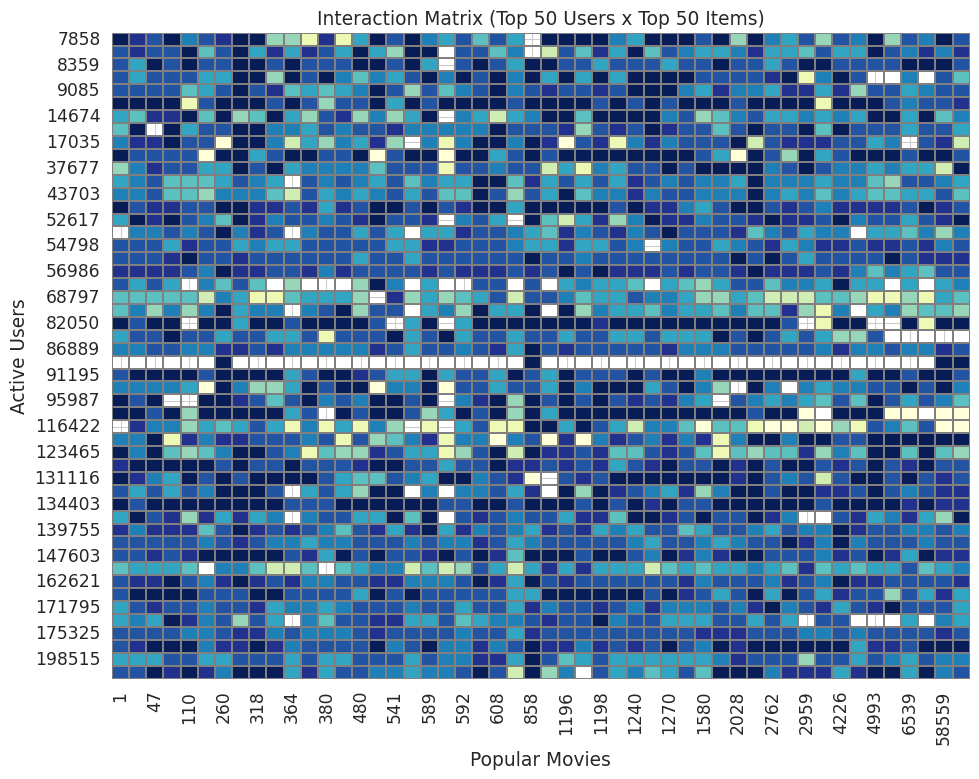

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_sparsity_heatmap.pdf
[-] Generating Plot 5: Correlation...


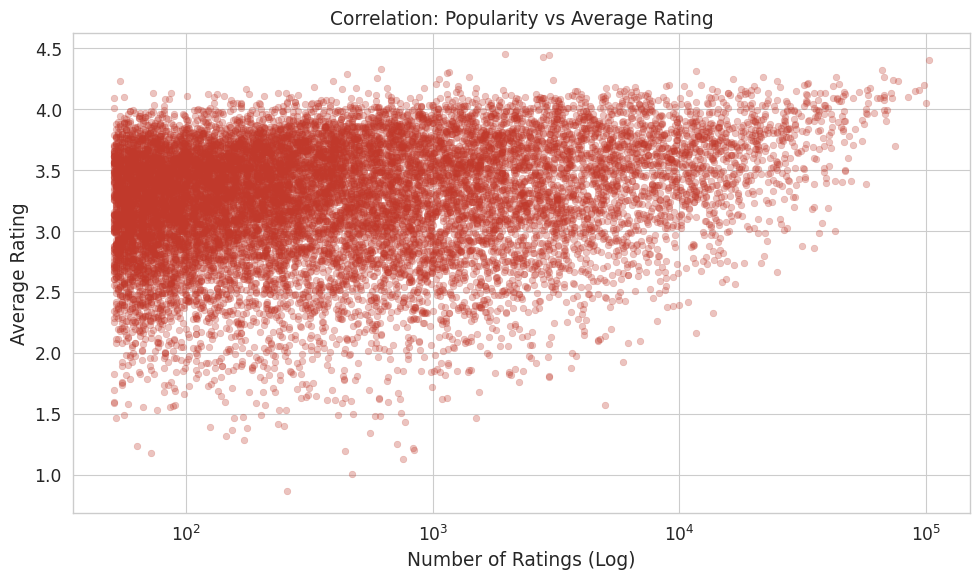

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_correlation.pdf
✅ Practical 0 Complete. All files saved to Drive.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage Collector

# --- 1. Setup Paths & Configuration ---
BASE_DIR = '/content/drive/MyDrive/ML_at_scale'
DATA_DIR = os.path.join(BASE_DIR, 'ml-32m')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

# Create the figures directory if it doesn't exist
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    print(f"[-] Created directory: {FIGURES_DIR}")
else:
    print(f"[-] Saving results to: {FIGURES_DIR}")

# Plotting Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['figure.figsize'] = (12, 6)
# We save as PDF for reports (vector quality) and display PNG inline

# --- 2. Optimized Data Loading ---
print("[-] Loading data (this may take 1-2 minutes)...")

ratings_path = os.path.join(DATA_DIR, 'ratings.csv')
movies_path = os.path.join(DATA_DIR, 'movies.csv')

# Optimization: Int32 and Float32 reduce RAM usage by 50%
dtypes_ratings = {
    'userId': 'int32',
    'movieId': 'int32',
    'rating': 'float32',
    'timestamp': 'int64'
}

df_ratings = pd.read_csv(ratings_path, dtype=dtypes_ratings)
df_movies = pd.read_csv(movies_path, dtype={'movieId': 'int32'})

# Convert timestamp to date object
print("[-] Converting timestamps...")
df_ratings['date'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

print(f"[+] Data Loaded. {len(df_ratings):,} ratings.")

# =========================================================
#  PLOT 1: Global Rating Distribution
# =========================================================
print("[-] Generating Plot 1: Rating Distribution...")

plt.figure(figsize=(10, 5))
counts = df_ratings['rating'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

plt.title("Global Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_rating_distribution.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
# PLOT 2: Long Tail (Power Law)
# =========================================================
print("[-] Generating Plot 2: Long Tail Distribution...")

# Get rating counts per movie
item_counts = df_ratings['movieId'].value_counts().values # Sorted Descending

plt.figure(figsize=(10, 6))
plt.plot(item_counts, color='#2E86C1', linewidth=2, label="Actual Data")

# Theoretical Reference Line (Power Law: y = k * x^-alpha)
x = np.arange(1, len(item_counts) + 1)
alpha = 0.8  # Typical slope for social data
y_ref = item_counts[0] * (x ** -alpha)
plt.plot(x, y_ref, 'r--', label=r'Power Law Ref ($\alpha \approx 0.8$)')

plt.yscale('log')
plt.xscale('log')
plt.title("Long Tail Distribution (Item Popularity)")
plt.xlabel("Item Rank (Log)")
plt.ylabel("Number of Ratings (Log)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_long_tail.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
#  PLOT 3: Temporal Evolution
# =========================================================
print("[-] Generating Plot 3: Temporal Evolution...")

# Resample by Month End ('ME')
monthly_counts = df_ratings.set_index('date').resample('ME').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, color='purple', linewidth=2)

plt.title("Evolution of Ratings Over Time")
plt.xlabel("Year")
plt.ylabel("Ratings per Month")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_temporal_evolution.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
#  PLOT 4: Sparsity Heatmap (Top 50x50)
# =========================================================
print("[-] Generating Plot 4: Interaction Heatmap...")

top_n = 50
top_users = df_ratings['userId'].value_counts().index[:top_n]
top_items = df_ratings['movieId'].value_counts().index[:top_n]

# Filter Data (Crucial step for RAM)
mask = (df_ratings['userId'].isin(top_users)) & (df_ratings['movieId'].isin(top_items))
df_small = df_ratings[mask]

# Create Pivot Table
heatmap_matrix = df_small.pivot(index='userId', columns='movieId', values='rating')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cbar=False, cmap="YlGnBu", linewidths=0.05, linecolor='gray')

plt.title(f"Interaction Matrix (Top {top_n} Users x Top {top_n} Items)")
plt.xlabel("Popular Movies")
plt.ylabel("Active Users")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_sparsity_heatmap.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
#  PLOT 5: Popularity vs Quality Correlation
# =========================================================
print("[-] Generating Plot 5: Correlation...")

# Group by movie
movie_stats = df_ratings.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['count', 'mean']

# Filter noise (movies with < 50 ratings)
robust_movies = movie_stats[movie_stats['count'] > 50]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='count', y='mean', data=robust_movies, alpha=0.3, edgecolor=None, color="#C0392B")

plt.xscale('log')
plt.title("Correlation: Popularity vs Average Rating")
plt.xlabel("Number of Ratings (Log)")
plt.ylabel("Average Rating")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_correlation.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

print(" Practical 0 Complete. All files saved to Drive.")

In [ ]:
movies_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/movies.csv')

In [ ]:
links_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/links.csv')

In [ ]:
ratings_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/ratings.csv')

In [ ]:
tags_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/tags.csv')

[-] Loading dataset (Pandas)...
[+] Loaded 32,000,204 ratings.
[-] Building ID Mappings...
[-] Converting DataFrame columns to internal indices...
[-] Building 'List of Lists' structures for 200948 users and 84432 items...
[+] Structures built in 40.05 seconds.

--- Board Verification (First User) ---
idx_to_userid[0] = 1
data_by_user[0] (First 5): [(16, 4.0), (24, 1.0), (28, 2.0), (29, 5.0), (31, 5.0)]

--- Board Verification (First Movie) ---
idx_to_movieid[0] = 1
data_by_movie[0] (First 5): [(9, 2.5), (10, 3.0), (16, 4.0), (18, 3.0), (19, 5.0)]

[-] Calculating Degrees for Plots...


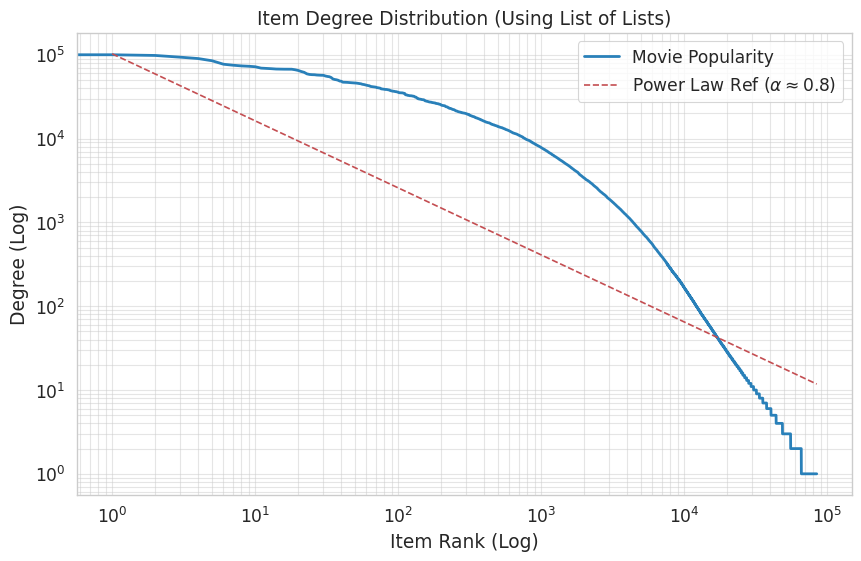

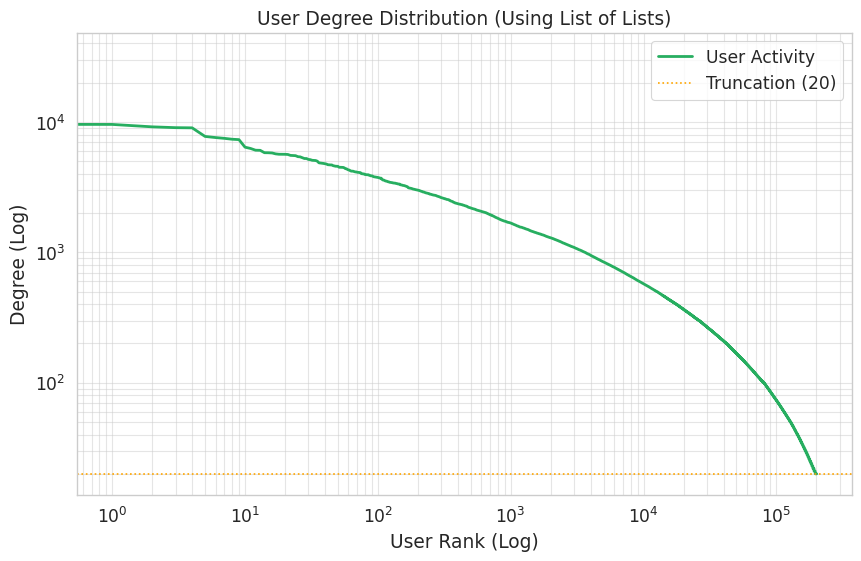

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Configuration ---
BASE_DIR = '/content/drive/MyDrive/ML_at_scale'
DATA_DIR = os.path.join(BASE_DIR, 'ml-32m')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
RATINGS_PATH = os.path.join(DATA_DIR, 'ratings.csv')

# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)

# --- 1. Load Data ---
print("[-] Loading dataset (Pandas)...")
df = pd.read_csv(RATINGS_PATH, dtype={
    'userId': 'int32',
    'movieId': 'int32',
    'rating': 'float32'
})
print(f"[+] Loaded {len(df):,} ratings.")

# --- 2. ID Mapping (The "Map" circle on the board) ---
print("[-] Building ID Mappings...")

# Unique sorted IDs
unique_users = np.unique(df['userId'])
unique_items = np.unique(df['movieId'])

n_users = len(unique_users)
n_items = len(unique_items)

#  Board Logic: userid_to_idx = {"A": 0, "B": 1}
userid_to_idx = {original: i for i, original in enumerate(unique_users)}
movieid_to_idx = {original: i for i, original in enumerate(unique_items)}

# Board Logic: idx_to_userid = ["A", "B"]
idx_to_userid = list(unique_users)
idx_to_movieid = list(unique_items)

# Apply mapping to DataFrame for faster iteration
print("[-] Converting DataFrame columns to internal indices...")
df['u_idx'] = df['userId'].map(userid_to_idx)
df['i_idx'] = df['movieId'].map(movieid_to_idx)

# --- 3. Building Adjacency Lists (The main part of the board) ---
print(f"[-] Building 'List of Lists' structures for {n_users} users and {n_items} items...")
t0 = time.time()

# Initialize empty lists of lists
# data_by_user = [ [], [], ... ]
data_by_user = [[] for _ in range(n_users)]

# data_by_movie = [ [], [], ... ]
data_by_movie = [[] for _ in range(n_items)]

# Iterate efficiently using zip (much faster than iterrows)
# We fill both lists in one pass
# Row structure: (user_idx, item_idx, rating)
for u, i, r in zip(df['u_idx'], df['i_idx'], df['rating']):
    # Logic: data_by_user[0] = [(0, 5), (1, 2)]
    data_by_user[u].append((i, r))

    # Logic: data_by_movie[0] = [(0, 5)]
    data_by_movie[i].append((u, r))

print(f"[+] Structures built in {time.time() - t0:.2f} seconds.")

# --- Verification (Print first few like the board) ---
print("\n--- Board Verification (First User) ---")
u_idx_0 = 0
print(f"idx_to_userid[{u_idx_0}] = {idx_to_userid[u_idx_0]}")
print(f"data_by_user[{u_idx_0}] (First 5): {data_by_user[u_idx_0][:5]}")

print("\n--- Board Verification (First Movie) ---")
i_idx_0 = 0
print(f"idx_to_movieid[{i_idx_0}] = {idx_to_movieid[i_idx_0]}")
print(f"data_by_movie[{i_idx_0}] (First 5): {data_by_movie[i_idx_0][:5]}")


# --- 4. Power Law Analysis using Lists ---
print("\n[-] Calculating Degrees for Plots...")

# To get degree, we just take the length of the list!
# len(data_by_user[u]) is the number of ratings user u gave.
user_degrees = [len(ratings) for ratings in data_by_user]
item_degrees = [len(ratings) for ratings in data_by_movie]

# --- PLOT 1: Item Power Law ---
plt.figure(figsize=(10, 6))
sorted_item_degrees = np.sort(item_degrees)[::-1]
plt.plot(sorted_item_degrees, color='#2980B9', linewidth=2, label="Movie Popularity")

# Ref line
x = np.arange(1, len(sorted_item_degrees) + 1)
y_ref = sorted_item_degrees[0] * (x ** -0.8)
plt.plot(x, y_ref, 'r--', label=r'Power Law Ref ($\alpha \approx 0.8$)')

plt.xscale('log')
plt.yscale('log')
plt.title("Item Degree Distribution (Using List of Lists)")
plt.xlabel("Item Rank (Log)")
plt.ylabel("Degree (Log)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig(os.path.join(FIGURES_DIR, 'p1_list_power_law_items.pdf'), bbox_inches='tight')
plt.show()

# --- PLOT 2: User Power Law ---
plt.figure(figsize=(10, 6))
sorted_user_degrees = np.sort(user_degrees)[::-1]
plt.plot(sorted_user_degrees, color='#27AE60', linewidth=2, label="User Activity")
plt.axhline(y=20, color='orange', linestyle=':', label="Truncation (20)")

plt.xscale('log')
plt.yscale('log')
plt.title("User Degree Distribution (Using List of Lists)")
plt.xlabel("User Rank (Log)")
plt.ylabel("Degree (Log)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig(os.path.join(FIGURES_DIR, 'p1_list_power_law_users.pdf'), bbox_inches='tight')
plt.show()

    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=0.5)...
    Epoch 1: Train RMSE=0.8611 | Test RMSE=0.8714 | 0.9s
    Epoch 2: Train RMSE=0.8465 | Test RMSE=0.8567 | 0.9s
    Epoch 3: Train RMSE=0.8457 | Test RMSE=0.8560 | 0.9s
    Epoch 4: Train RMSE=0.8457 | Test RMSE=0.8560 | 0.9s
    Epoch 5: Train RMSE=0.8457 | Test RMSE=0.8560 | 1.1s
    Epoch 6: Train RMSE=0.8457 | Test RMSE=0.8560 | 1.3s
    Epoch 7: Train RMSE=0.8457 | Test RMSE=0.8560 | 1.3s
    Epoch 8: Train RMSE=0.8457 | Test RMSE=0.8559 | 1.2s
    Epoch 9: Train RMSE=0.8457 | Test RMSE=0.8559 | 0.9s
    Epoch 10: Train RMSE=0.8457 | Test RMSE=0.8559 | 1.0s


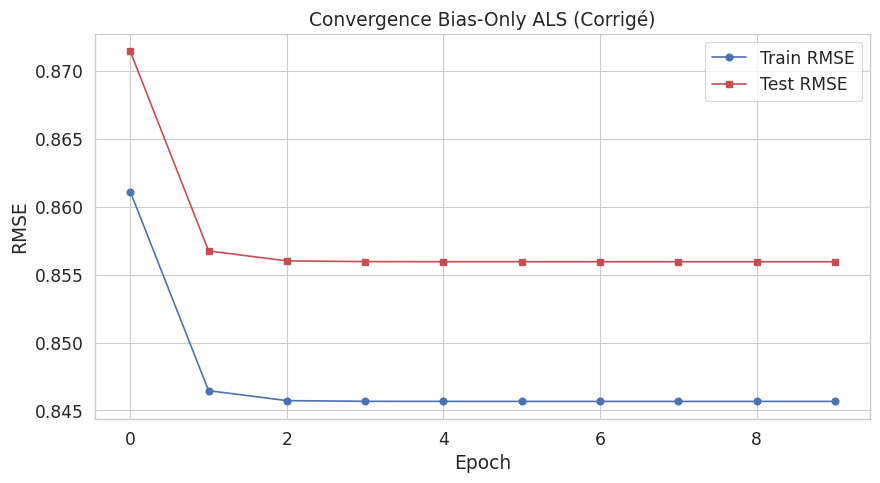

Final Train RMSE: 0.8457
Final Test RMSE: 0.8559


In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
import gc

# --- 1. Load Data into Sparse Matrix ---
print("[-] Loading dataset into Sparse Matrix...")

class CorrectedBiasALS:
    def __init__(self, lambda_reg=3.03811, n_epochs=10):
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.mu = 0.0
        self.b_u = None
        self.b_i = None
        self.loss_history = []
        self.train_rmse_history = []
        self.test_rmse_history = []

    def fit(self, R_train, R_test):
        n_u, n_i = R_train.shape

        # 1. Initialisation
        self.mu = np.mean(R_train.data)
        self.b_u = np.zeros(n_u, dtype=np.float32)
        self.b_i = np.zeros(n_i, dtype=np.float32)

        # 2. Création de la Matrice Binaire (P)
        # P[u,i] = 1 si noté, 0 sinon.
        # Indispensable pour sommer les biais correctement sans multiplier par la note.
        print("    Création de la matrice binaire (Indicateur)...")
        P_train = R_train.copy()
        P_train.data = np.ones_like(P_train.data, dtype=np.float32)

        # Comptes (Dénominateurs)
        user_counts = np.array(R_train.getnnz(axis=1)).flatten().astype(np.float32)

        print("    Conversion CSC...")
        R_csc = R_train.tocsc()
        P_csc = P_train.tocsc() # Version binaire en colonnes
        item_counts = np.array(R_train.getnnz(axis=0)).flatten().astype(np.float32)

        print(f"    Début de l'entraînement (Lambda={self.lambda_reg})...")

        for epoch in range(self.n_epochs):
            t0 = time.time()

            # --- UPDATE USER BIAS ---
            # b_u = (sum(r_ui - mu - b_i)) / (count + lambda)

            # A. Somme des (r_ui - mu)
            # Astuce : sum(r_ui) - count * mu
            sum_ratings = np.array(R_train.sum(axis=1)).flatten()

            # B. Somme des b_i (CORRECTION ICI)
            # On utilise P_train (binaire) au lieu de R_train (notes)
            sum_bi = P_train.dot(self.b_i)

            numer = sum_ratings - (user_counts * self.mu) - sum_bi
            denom = user_counts + self.lambda_reg
            self.b_u = np.divide(numer, denom, where=denom!=0)

            # --- UPDATE ITEM BIAS ---
            # b_i = (sum(r_ui - mu - b_u)) / (count + lambda)

            sum_ratings_i = np.array(R_csc.sum(axis=0)).flatten()

            # CORRECTION ICI : On utilise P_train transposée
            sum_bu = P_train.T.dot(self.b_u)

            numer = sum_ratings_i - (item_counts * self.mu) - sum_bu
            denom = item_counts + self.lambda_reg
            self.b_i = np.divide(numer, denom, where=denom!=0)

            # --- METRICS ---
            # Calculer la Loss à chaque itération est lourd sur 32M
            # On calcule seulement le RMSE
            train_rmse = self._compute_rmse(R_train)
            test_rmse = self._compute_rmse(R_test)

            self.train_rmse_history.append(train_rmse)
            self.test_rmse_history.append(test_rmse)

            print(f"    Epoch {epoch+1}: Train RMSE={train_rmse:.4f} | Test RMSE={test_rmse:.4f} | {time.time()-t0:.1f}s")

    def _compute_rmse(self, R):
        if R.nnz == 0: return 0.0
        rows, cols = R.nonzero()
        # Prédiction vectorisée
        pred = self.mu + self.b_u[rows] + self.b_i[cols]
        error = R.data - pred
        return np.sqrt(np.mean(error**2))

# ==========================================
# EXÉCUTION
# ==========================================

# On utilise Lambda=0.5 qui est standard pour MovieLens
model = CorrectedBiasALS(lambda_reg=0.5, n_epochs=10)
model.fit(R_train, R_test)

# ==========================================
# PLOTTING
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(model.train_rmse_history, 'b-o', label="Train RMSE")
plt.plot(model.test_rmse_history, 'r-s', label="Test RMSE")
plt.title("Convergence Bias-Only ALS (Corrigé)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ML_at_scale/figures/p2_corrected_rmse.pdf')
plt.show()

print(f"Final Train RMSE: {model.train_rmse_history[-1]:.4f}")
print(f"Final Test RMSE: {model.test_rmse_history[-1]:.4f}")

<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-795858690.py:66: SyntaxWarning: invalid escape sequence '\l'
  plt.axvline(x=best_lambda, color='green', linestyle='--', label=f'Optimal $\lambda={best_lambda}$')
/tmp/ipython-input-795858690.py:69: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Hyperparameter Tuning: Effect of Regularization ($\lambda$)")
/tmp/ipython-input-795858690.py:70: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Regularization Parameter $\lambda$ (Log Scale)")


[-] Starting Grid Search on: [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
------------------------------------------------------------
Lambda     | Train RMSE   | Test RMSE    | Time (s)  
------------------------------------------------------------
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=0.05)...
    Epoch 1: Train RMSE=0.8612 | Test RMSE=0.8719 | 1.3s
    Epoch 2: Train RMSE=0.8464 | Test RMSE=0.8571 | 1.2s
    Epoch 3: Train RMSE=0.8456 | Test RMSE=0.8564 | 1.0s
    Epoch 4: Train RMSE=0.8456 | Test RMSE=0.8563 | 0.9s
    Epoch 5: Train RMSE=0.8456 | Test RMSE=0.8563 | 0.9s
0.05       | 0.8456       | 0.8563       | 7.1       
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=0.1)...
    Epoch 1: Train RMSE=0.8612 | Test RMSE=0.8719 | 1.0s
    Epoch 2: Train RMSE=0.8464 | Test RMSE=0.8570 | 1.0s
    Epoch 3: Train RMSE=0.8456 | Test RMSE=0.8563 | 0.9s
    Epoch 4:

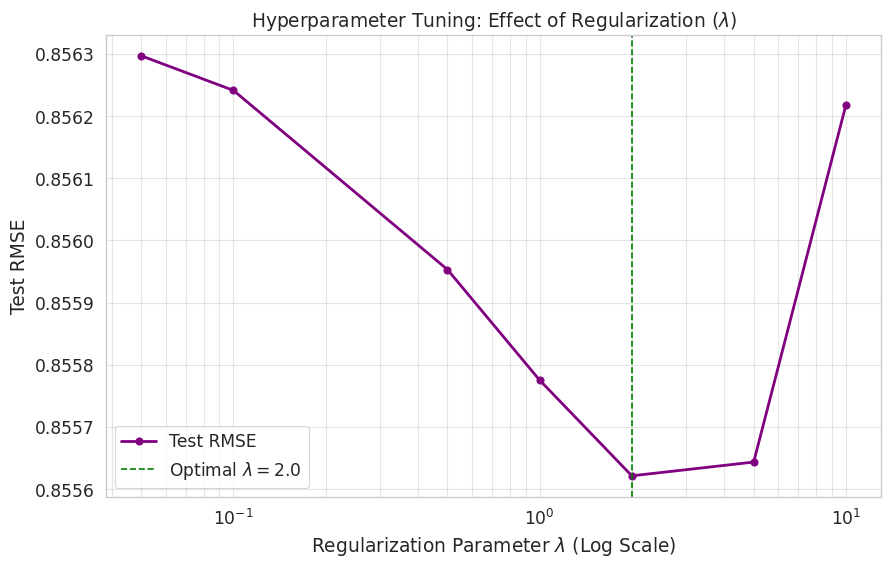

[-] Training Final Model with Best Lambda = 2.0...
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=2.0)...
    Epoch 1: Train RMSE=0.8611 | Test RMSE=0.8706 | 1.0s
    Epoch 2: Train RMSE=0.8469 | Test RMSE=0.8564 | 0.9s
    Epoch 3: Train RMSE=0.8462 | Test RMSE=0.8557 | 0.9s
    Epoch 4: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 5: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 6: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 7: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.2s
    Epoch 8: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.3s
    Epoch 9: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.3s
    Epoch 10: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.1s
    Epoch 11: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 12: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 13: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 14: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 15: Train RMSE=0.84

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tune_lambda(R_train, R_test, candidate_lambdas):
    """
    Performs a Grid Search to find the best regularization parameter (lambda).
    """
    results = []
    best_rmse = float('inf')
    best_lambda = None

    print(f"[-] Starting Grid Search on: {candidate_lambdas}")
    print("-" * 60)
    print(f"{'Lambda':<10} | {'Train RMSE':<12} | {'Test RMSE':<12} | {'Time (s)':<10}")
    print("-" * 60)

    for l_reg in candidate_lambdas:
        start_time = time.time()

        # Initialize and Train
        # We only need ~5 epochs to see convergence for tuning
        model = CorrectedBiasALS(lambda_reg=l_reg, n_epochs=5)
        model.fit(R_train, R_test)

        # Get final metrics
        final_train_rmse = model.train_rmse_history[-1]
        final_test_rmse = model.test_rmse_history[-1]
        duration = time.time() - start_time

        # Store results
        results.append((l_reg, final_train_rmse, final_test_rmse))

        print(f"{l_reg:<10.2f} | {final_train_rmse:<12.4f} | {final_test_rmse:<12.4f} | {duration:<10.1f}")

        # Track best
        if final_test_rmse < best_rmse:
            best_rmse = final_test_rmse
            best_lambda = l_reg

    print("-" * 60)
    print(f"🏆 BEST LAMBDA: {best_lambda} (RMSE: {best_rmse:.4f})")
    return best_lambda, results

# ==========================================
# 1. EXECUTE TUNING
# ==========================================

# Candidates to test.
# Theory:
# - Too low (<0.01) -> Overfitting (Model memorizes noise)
# - Too high (>10)  -> Underfitting (Biases shrunk towards 0)
candidates = [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

best_lambda, experiment_results = tune_lambda(R_train, R_test, candidates)

# ==========================================
# 2. VISUALIZE TUNING (Important for Report)
# ==========================================
lambdas = [x[0] for x in experiment_results]
test_errors = [x[2] for x in experiment_results]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, test_errors, 'o-', color='purple', linewidth=2, label='Test RMSE')

# Highlight Best
plt.axvline(x=best_lambda, color='green', linestyle='--', label=f'Optimal $\lambda={best_lambda}$')

plt.xscale('log') # Log scale is better for lambda
plt.title("Hyperparameter Tuning: Effect of Regularization ($\lambda$)")
plt.xlabel("Regularization Parameter $\lambda$ (Log Scale)")
plt.ylabel("Test RMSE")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

save_path = '/content/drive/MyDrive/ML_at_scale/figures/p2_hyperparameter_tuning.pdf'
plt.savefig(save_path, bbox_inches='tight')
plt.show()

# ==========================================
# 3. TRAIN FINAL MODEL
# ==========================================
print(f"[-] Training Final Model with Best Lambda = {best_lambda}...")
final_model = CorrectedBiasALS(lambda_reg=best_lambda, n_epochs=15)
final_model.fit(R_train, R_test)

<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:73: SyntaxWarning: invalid escape sequence '\l'
<>:74: SyntaxWarning: invalid escape sequence '\l'
<>:97: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:73: SyntaxWarning: invalid escape sequence '\l'
<>:74: SyntaxWarning: invalid escape sequence '\l'
<>:97: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3415501316.py:70: SyntaxWarning: invalid escape sequence '\l'
  plt.axvline(x=best_lambda, color='green', linestyle='--', label=f'Optimal $\lambda={best_lambda}$')
/tmp/ipython-input-3415501316.py:73: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Hyperparameter Tuning: Effect of Regularization ($\lambda$)")
/tmp/ipython-input-3415501316.py:74: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Regularization Parameter $\lambda$ (Log Scale)")
/tmp/ipython-input-3415501316.py:97: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Final Converge

[-] Starting Grid Search on: [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
-----------------------------------------------------------------
Lambda     | Train RMSE   | Test RMSE    | Time (s)  
-----------------------------------------------------------------
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=0.05)...
    Epoch 1: Train RMSE=0.8612 | Test RMSE=0.8719 | 1.6s
    Epoch 2: Train RMSE=0.8464 | Test RMSE=0.8571 | 1.0s
    Epoch 3: Train RMSE=0.8456 | Test RMSE=0.8564 | 1.0s
    Epoch 4: Train RMSE=0.8456 | Test RMSE=0.8563 | 1.0s
    Epoch 5: Train RMSE=0.8456 | Test RMSE=0.8563 | 1.0s
0.05       | 0.8456       | 0.8563       | 7.8       
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=0.1)...
    Epoch 1: Train RMSE=0.8612 | Test RMSE=0.8719 | 1.3s
    Epoch 2: Train RMSE=0.8464 | Test RMSE=0.8570 | 1.2s
    Epoch 3: Train RMSE=0.8456 | Test RMSE=0.8563 | 1.0s
  

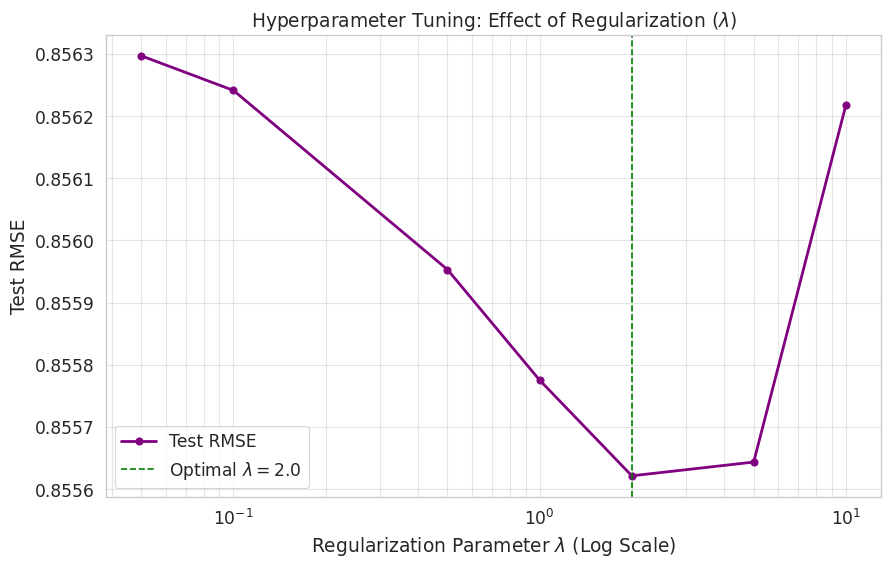

[+] Tuning plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p2_hyperparameter_tuning.pdf

[-] Training Final Model with Best Lambda = 2.0...
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=2.0)...
    Epoch 1: Train RMSE=0.8611 | Test RMSE=0.8706 | 1.3s
    Epoch 2: Train RMSE=0.8469 | Test RMSE=0.8564 | 1.3s
    Epoch 3: Train RMSE=0.8462 | Test RMSE=0.8557 | 1.0s
    Epoch 4: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 5: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 6: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 7: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 8: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 9: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 10: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 11: Train RMSE=0.8461 | Test RMSE=0.8556 | 1.0s
    Epoch 12: Train RMSE=0.8461 | Test RMSE=0.8556 | 0.9s
    Epoch 13: Train RMSE=0.8461 | Test RMSE=0.

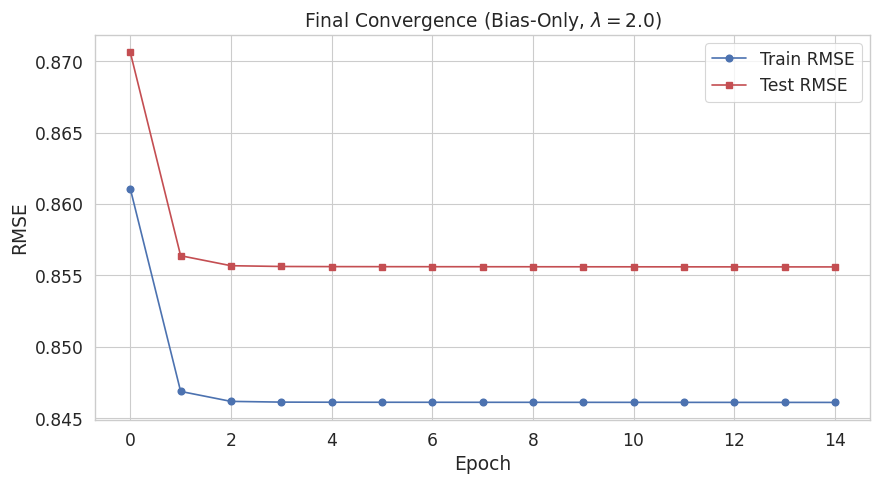

[+] Final convergence plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p2_final_convergence.pdf
[+] Final model saved to: /content/drive/MyDrive/ML_at_scale/ml-32m/p2_bias_model.pkl


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import pickle

# --- Paths Configuration ---
BASE_DIR = '/content/drive/MyDrive/ML_at_scale'
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
DATA_DIR = os.path.join(BASE_DIR, 'ml-32m')

# Ensure directories exist
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ==========================================
# 1. TUNING FUNCTION
# ==========================================
def tune_lambda(R_train, R_test, candidate_lambdas):
    """
    Performs a Grid Search to find the best regularization parameter (lambda).
    """
    results = []
    best_rmse = float('inf')
    best_lambda = None

    print(f"[-] Starting Grid Search on: {candidate_lambdas}")
    print("-" * 65)
    print(f"{'Lambda':<10} | {'Train RMSE':<12} | {'Test RMSE':<12} | {'Time (s)':<10}")
    print("-" * 65)

    for l_reg in candidate_lambdas:
        start_time = time.time()

        # Train for fewer epochs just to check convergence direction
        model = CorrectedBiasALS(lambda_reg=l_reg, n_epochs=5)
        model.fit(R_train, R_test)

        final_train_rmse = model.train_rmse_history[-1]
        final_test_rmse = model.test_rmse_history[-1]
        duration = time.time() - start_time

        results.append((l_reg, final_train_rmse, final_test_rmse))
        print(f"{l_reg:<10.2f} | {final_train_rmse:<12.4f} | {final_test_rmse:<12.4f} | {duration:<10.1f}")

        if final_test_rmse < best_rmse:
            best_rmse = final_test_rmse
            best_lambda = l_reg

    print("-" * 65)
    print(f"🏆 BEST LAMBDA: {best_lambda} (RMSE: {best_rmse:.4f})")
    return best_lambda, results

# ==========================================
# 2. EXECUTE GRID SEARCH
# ==========================================
candidates = [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# Run Tuning
best_lambda, experiment_results = tune_lambda(R_train, R_test, candidates)

# ==========================================
# 3. SAVE TUNING PLOT
# ==========================================
lambdas = [x[0] for x in experiment_results]
test_errors = [x[2] for x in experiment_results]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, test_errors, 'o-', color='purple', linewidth=2, label='Test RMSE')
plt.axvline(x=best_lambda, color='green', linestyle='--', label=f'Optimal $\lambda={best_lambda}$')

plt.xscale('log')
plt.title("Hyperparameter Tuning: Effect of Regularization ($\lambda$)")
plt.xlabel("Regularization Parameter $\lambda$ (Log Scale)")
plt.ylabel("Test RMSE")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

# Save to Figures Directory
tune_plot_path = os.path.join(FIGURES_DIR, 'p2_hyperparameter_tuning.pdf')
plt.savefig(tune_plot_path, bbox_inches='tight')
plt.show()
print(f"[+] Tuning plot saved to: {tune_plot_path}")

# ==========================================
# 4. TRAIN & SAVE FINAL MODEL
# ==========================================
print(f"\n[-] Training Final Model with Best Lambda = {best_lambda}...")

final_model = CorrectedBiasALS(lambda_reg=best_lambda, n_epochs=15)
final_model.fit(R_train, R_test)

# Plot Final Convergence
plt.figure(figsize=(10, 5))
plt.plot(final_model.train_rmse_history, 'b-o', label="Train RMSE")
plt.plot(final_model.test_rmse_history, 'r-s', label="Test RMSE")
plt.title(f"Final Convergence (Bias-Only, $\lambda={best_lambda}$)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)

# Save Final Convergence Plot
conv_plot_path = os.path.join(FIGURES_DIR, 'p2_final_convergence.pdf')
plt.savefig(conv_plot_path, bbox_inches='tight')
plt.show()
print(f"[+] Final convergence plot saved to: {conv_plot_path}")

# Save Model Weights (Pickle)
# We need this for the Streamlit App later!
model_path = os.path.join(DATA_DIR, 'p2_bias_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'mu': final_model.mu,
        'b_u': final_model.b_u,
        'b_i': final_model.b_i,
        'lambda': best_lambda
    }, f)

print(f"[+] Final model saved to: {model_path}")

<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\l'
<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3231936752.py:85: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Random Search: Regularization $\lambda$ vs RMSE")
/tmp/ipython-input-3231936752.py:86: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Regularization Parameter $\lambda$ (Log Scale)")


[-] Starting Random Search (12 iterations)...
-----------------------------------------------------------------
Iter  | Lambda     | Train RMSE   | Test RMSE    | Time (s)  
-----------------------------------------------------------------
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=0.3537629385773666)...
    Epoch 1: Train RMSE=0.8611 | Test RMSE=0.8716 | 1.3s
    Epoch 2: Train RMSE=0.8464 | Test RMSE=0.8568 | 1.0s
    Epoch 3: Train RMSE=0.8457 | Test RMSE=0.8561 | 1.0s
    Epoch 4: Train RMSE=0.8456 | Test RMSE=0.8560 | 1.0s
    Epoch 5: Train RMSE=0.8456 | Test RMSE=0.8560 | 0.9s
1     | 0.3538     | 0.8456       | 0.8560       | 9.5       
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=14.52111811342515)...
    Epoch 1: Train RMSE=0.8619 | Test RMSE=0.8693 | 1.0s
    Epoch 2: Train RMSE=0.8503 | Test RMSE=0.8576 | 1.0s
    Epoch 3: Train RMSE=0.8498 | Tes

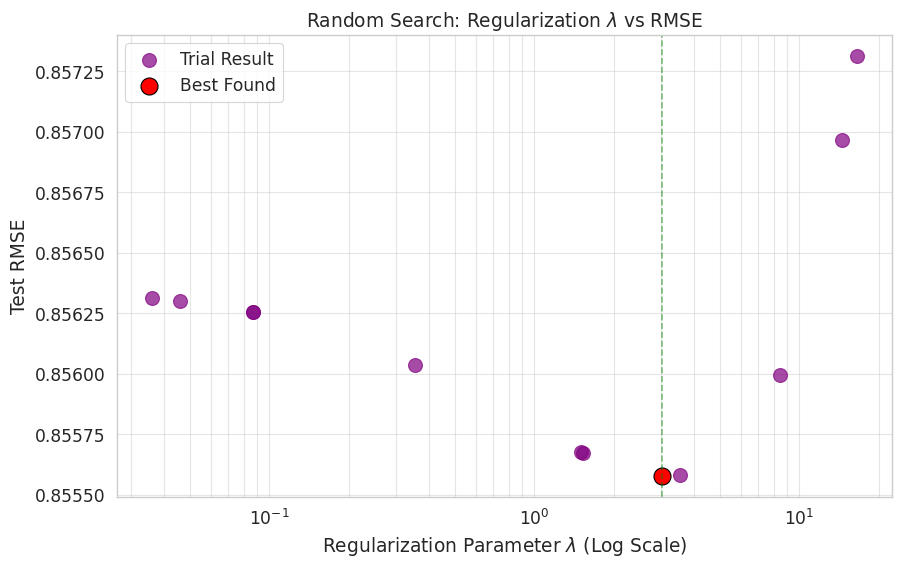

[+] Random Search plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p2_random_search_tuning.pdf

[-] Training Final Model with Random Search Best Lambda = 3.03811...
    Création de la matrice binaire (Indicateur)...
    Conversion CSC...
    Début de l'entraînement (Lambda=3.0381080667119558)...
    Epoch 1: Train RMSE=0.8611 | Test RMSE=0.8703 | 1.3s
    Epoch 2: Train RMSE=0.8472 | Test RMSE=0.8563 | 1.2s
    Epoch 3: Train RMSE=0.8465 | Test RMSE=0.8556 | 1.2s
    Epoch 4: Train RMSE=0.8464 | Test RMSE=0.8556 | 1.0s
    Epoch 5: Train RMSE=0.8464 | Test RMSE=0.8556 | 0.9s
    Epoch 6: Train RMSE=0.8464 | Test RMSE=0.8556 | 0.9s
    Epoch 7: Train RMSE=0.8464 | Test RMSE=0.8556 | 0.9s
    Epoch 8: Train RMSE=0.8464 | Test RMSE=0.8556 | 0.9s
    Epoch 9: Train RMSE=0.8464 | Test RMSE=0.8556 | 0.9s
    Epoch 10: Train RMSE=0.8464 | Test RMSE=0.8556 | 0.9s
    Epoch 11: Train RMSE=0.8464 | Test RMSE=0.8556 | 1.0s
    Epoch 12: Train RMSE=0.8464 | Test RMSE=0.8556 | 1.0s
    Epo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle

# --- Paths Configuration ---
BASE_DIR = '/content/drive/MyDrive/ML_at_scale'
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
DATA_DIR = os.path.join(BASE_DIR, 'ml-32m')

# Ensure directories exist
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ==========================================
# 1. RANDOM SEARCH FUNCTION
# ==========================================
def random_search_lambda(R_train, R_test, n_iter=10):
    """
    Performs Random Search for Lambda using a Log-Uniform distribution.
    Range: 10^-2 (0.01) to 10^1.3 (~20)
    """
    results = []
    best_rmse = float('inf')
    best_lambda = None

    print(f"[-] Starting Random Search ({n_iter} iterations)...")
    print("-" * 65)
    print(f"{'Iter':<5} | {'Lambda':<10} | {'Train RMSE':<12} | {'Test RMSE':<12} | {'Time (s)':<10}")
    print("-" * 65)

    np.random.seed(42) # Reproducibility

    for i in range(n_iter):
        start_time = time.time()

        # SAMPLE LAMBDA (Log-Uniform)
        # We sample exponent x from [-1.5, 1.3] -> Lambda from [0.03, 20]
        exponent = np.random.uniform(-1.5, 1.3)
        l_reg = 10 ** exponent

        # Train for 5 epochs (Enough to see trend)
        model = CorrectedBiasALS(lambda_reg=l_reg, n_epochs=5)
        model.fit(R_train, R_test)

        final_train_rmse = model.train_rmse_history[-1]
        final_test_rmse = model.test_rmse_history[-1]
        duration = time.time() - start_time

        results.append((l_reg, final_test_rmse))

        print(f"{i+1:<5} | {l_reg:<10.4f} | {final_train_rmse:<12.4f} | {final_test_rmse:<12.4f} | {duration:<10.1f}")

        if final_test_rmse < best_rmse:
            best_rmse = final_test_rmse
            best_lambda = l_reg

    print("-" * 65)
    print(f"🏆 BEST LAMBDA: {best_lambda:.5f} (RMSE: {best_rmse:.4f})")
    return best_lambda, results

# ==========================================
# 2. EXECUTE RANDOM SEARCH
# ==========================================
# We run 12 iterations to get a good spread
best_lambda_rand, experiment_results = random_search_lambda(R_train, R_test, n_iter=12)

# ==========================================
# 3. VISUALIZE RANDOM SEARCH
# ==========================================
lambdas = [x[0] for x in experiment_results]
test_errors = [x[1] for x in experiment_results]

plt.figure(figsize=(10, 6))

# Use Scatter plot for Random Search (points are not ordered)
plt.scatter(lambdas, test_errors, color='purple', s=100, label='Trial Result', alpha=0.7)

# Highlight Best
plt.scatter([best_lambda_rand], [min(test_errors)], color='red', s=150, edgecolors='black', label='Best Found')
plt.axvline(x=best_lambda_rand, color='green', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.title("Random Search: Regularization $\lambda$ vs RMSE")
plt.xlabel("Regularization Parameter $\lambda$ (Log Scale)")
plt.ylabel("Test RMSE")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

# Save Plot
rs_plot_path = os.path.join(FIGURES_DIR, 'p2_random_search_tuning.pdf')
plt.savefig(rs_plot_path, bbox_inches='tight')
plt.show()
print(f"[+] Random Search plot saved to: {rs_plot_path}")

# ==========================================
# 4. TRAIN & SAVE FINAL MODEL (From Random Search)
# ==========================================
print(f"\n[-] Training Final Model with Random Search Best Lambda = {best_lambda_rand:.5f}...")

final_model = CorrectedBiasALS(lambda_reg=best_lambda_rand, n_epochs=15)
final_model.fit(R_train, R_test)

# Save Model
model_path = os.path.join(DATA_DIR, 'p2_bias_model_optimized.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'mu': final_model.mu,
        'b_u': final_model.b_u,
        'b_i': final_model.b_i,
        'lambda': best_lambda_rand
    }, f)

print(f"[+] Optimized model saved to: {model_path}")

[-] Converting to CSC...
[-] Starting Full ALS (K=8, Lambda=8.0)...
Epoch 1: Loss=1.87e+07 | Train=0.8408 | Test=0.8729 | 27.2s
Epoch 2: Loss=1.61e+07 | Train=0.7729 | Test=0.8240 | 4.4s
Epoch 3: Loss=1.52e+07 | Train=0.7478 | Test=0.8013 | 6.2s
Epoch 4: Loss=1.49e+07 | Train=0.7376 | Test=0.7918 | 4.5s
Epoch 5: Loss=1.47e+07 | Train=0.7328 | Test=0.7874 | 4.5s
Epoch 6: Loss=1.46e+07 | Train=0.7304 | Test=0.7853 | 6.5s
Epoch 7: Loss=1.45e+07 | Train=0.7291 | Test=0.7842 | 4.5s
Epoch 8: Loss=1.45e+07 | Train=0.7283 | Test=0.7835 | 5.1s
Epoch 9: Loss=1.45e+07 | Train=0.7277 | Test=0.7831 | 6.1s
Epoch 10: Loss=1.45e+07 | Train=0.7273 | Test=0.7828 | 4.5s


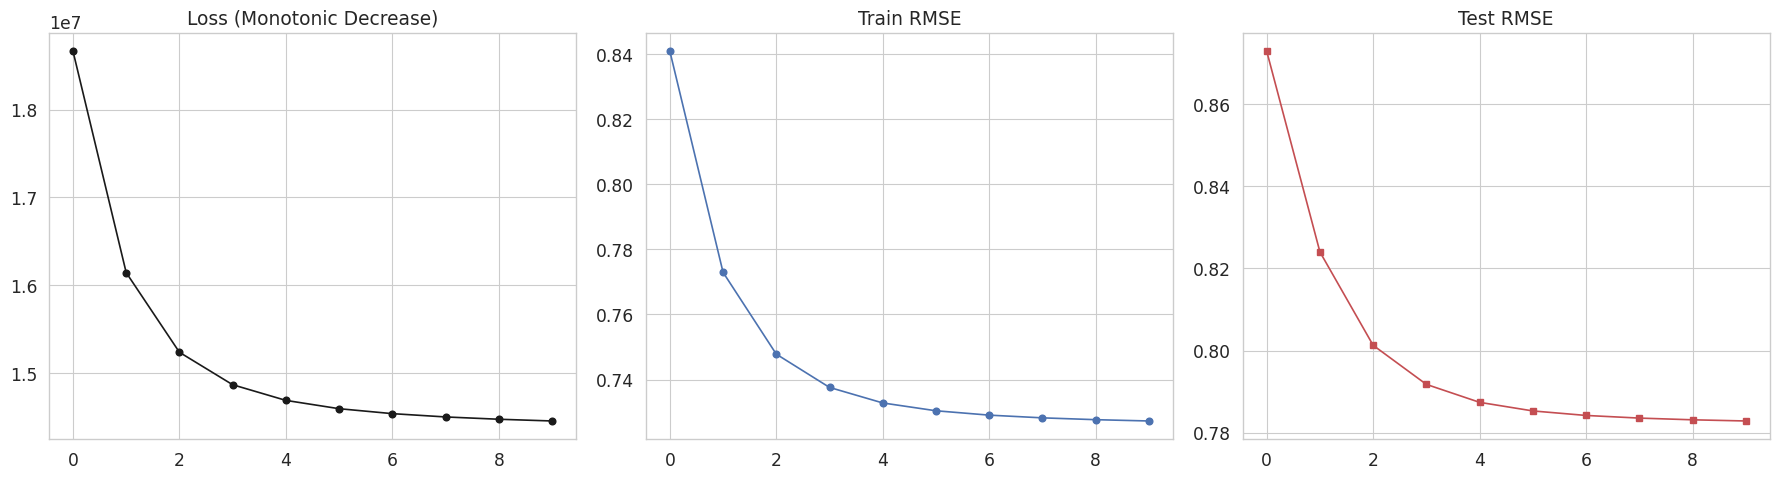

In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
import gc
from numba import njit, prange

# ==========================================
# 1. FIXED NUMBA KERNELS (Strict float32)
# ==========================================

@njit(parallel=True, fastmath=True)
def als_step_user(indptr, indices, ratings,
                  mu, b_u, b_i, U, V,
                  lambda_reg, n_factors):
    """
    Parallel update of User Biases and Factors (U).
    """
    n_users = len(indptr) - 1

    # STRICT TYPE ENFORCEMENT
    # Ensure lambda_reg is float32 so matrix A doesn't become float64
    reg_val = np.float32(lambda_reg)
    lambda_I = np.eye(n_factors, dtype=np.float32) * reg_val

    for u in prange(n_users):
        start = indptr[u]
        end = indptr[u+1]

        if start == end:
            continue

        u_indices = indices[start:end]
        u_ratings = ratings[start:end]

        # Slicing returns copies or views of correct type (float32)
        V_u = V[u_indices]
        b_i_u = b_i[u_indices]

        # --- 1. UPDATE BIAS ---
        # Predict rating based on factors ONLY
        # dot_products must be float32
        dot_products = np.zeros(len(u_indices), dtype=np.float32)
        for k in range(len(u_indices)):
            val = np.float32(0.0)
            for f in range(n_factors):
                val += U[u, f] * V_u[k, f]
            dot_products[k] = val

        residuals_bias = u_ratings - mu - b_i_u - dot_products

        numerator = np.sum(residuals_bias)
        denominator = np.float32(len(u_indices)) + reg_val
        b_u[u] = numerator / denominator

        # --- 2. UPDATE FACTOR U ---
        # A = V.T @ V + lambda*I
        # Both operands are float32, so result is float32
        A = (V_u.T @ V_u) + lambda_I

        # B = V.T @ (ratings - biases)
        # Recalculate residuals with NEW user bias
        residuals_vec = u_ratings - mu - b_u[u] - b_i_u
        B = V_u.T @ residuals_vec

        # Solve Ax = B. Both A and B are strictly float32 now.
        U[u] = np.linalg.solve(A, B)

@njit(parallel=True, fastmath=True)
def als_step_item(indptr, indices, ratings,
                  mu, b_u, b_i, U, V,
                  lambda_reg, n_factors):
    """
    Parallel update of Item Biases and Factors (V).
    """
    n_items = len(indptr) - 1

    reg_val = np.float32(lambda_reg)
    lambda_I = np.eye(n_factors, dtype=np.float32) * reg_val

    for i in prange(n_items):
        start = indptr[i]
        end = indptr[i+1]

        if start == end: continue

        i_indices = indices[start:end]
        i_ratings = ratings[start:end]

        U_i = U[i_indices]
        b_u_i = b_u[i_indices]

        # --- 1. UPDATE BIAS ---
        dot_products = np.zeros(len(i_indices), dtype=np.float32)
        for k in range(len(i_indices)):
            val = np.float32(0.0)
            for f in range(n_factors):
                val += U_i[k, f] * V[i, f]
            dot_products[k] = val

        residuals_bias = i_ratings - mu - b_u_i - dot_products
        numerator = np.sum(residuals_bias)
        denominator = np.float32(len(i_indices)) + reg_val
        b_i[i] = numerator / denominator

        # --- 2. UPDATE FACTOR V ---
        A = (U_i.T @ U_i) + lambda_I
        residuals_vec = i_ratings - mu - b_u_i - b_i[i]
        B = U_i.T @ residuals_vec

        V[i] = np.linalg.solve(A, B)

@njit(parallel=True, fastmath=True)
def calc_loss_rmse(indptr, indices, ratings, mu, b_u, b_i, U, V, lambda_reg):
    n_users = len(indptr) - 1
    total_sse = 0.0
    count = 0
    reg_val = np.float32(lambda_reg)

    for u in prange(n_users):
        start = indptr[u]
        end = indptr[u+1]
        if start == end: continue

        u_idx = indices[start:end]
        r_true = ratings[start:end]

        V_sub = V[u_idx]
        b_i_sub = b_i[u_idx]

        # Manual Dot Product Sum for memory safety
        # preds = mu + b_u[u] + b_i_sub + np.sum(U[u] * V_sub, axis=1)
        # Loop implementation to avoid large temp arrays
        for k in range(len(u_idx)):
            dot_val = 0.0
            for f in range(U.shape[1]):
                dot_val += U[u, f] * V_sub[k, f]

            pred = mu + b_u[u] + b_i_sub[k] + dot_val
            err = r_true[k] - pred
            total_sse += err * err

        count += len(r_true)

    rmse = np.sqrt(total_sse / count)

    # Regularization
    reg_loss = reg_val * (
        np.sum(b_u**2) + np.sum(b_i**2) +
        np.sum(U**2) + np.sum(V**2)
    )

    return total_sse + reg_loss, rmse

# ==========================================
# 2. CLASS WRAPPER
# ==========================================

class MatrixFactorizationALS:
    def __init__(self, n_factors=10, lambda_reg=5.0, n_epochs=10):
        self.K = n_factors
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs

        self.mu = 0.0
        self.b_u = None; self.b_i = None
        self.U = None; self.V = None

        self.loss_history = []
        self.train_rmse_history = []
        self.test_rmse_history = []

    def fit(self, R_train, R_test):
        n_users, n_items = R_train.shape
        self.mu = np.float32(np.mean(R_train.data))

        # Initialize (Float32)
        np.random.seed(42)
        self.U = np.random.normal(0, 0.1, (n_users, self.K)).astype(np.float32)
        self.V = np.random.normal(0, 0.1, (n_items, self.K)).astype(np.float32)
        self.b_u = np.zeros(n_users, dtype=np.float32)
        self.b_i = np.zeros(n_items, dtype=np.float32)

        # Prepare Numba Arrays
        tr_indptr = R_train.indptr
        tr_indices = R_train.indices
        tr_data = R_train.data.astype(np.float32)

        te_indptr = R_test.indptr
        te_indices = R_test.indices
        te_data = R_test.data.astype(np.float32)

        print("[-] Converting to CSC...")
        R_csc = R_train.tocsc()
        csc_indptr = R_csc.indptr
        csc_indices = R_csc.indices
        csc_data = R_csc.data.astype(np.float32)

        print(f"[-] Starting Full ALS (K={self.K}, Lambda={self.lambda_reg})...")

        for epoch in range(self.n_epochs):
            t0 = time.time()

            # 1. Update User
            als_step_user(
                tr_indptr, tr_indices, tr_data,
                self.mu, self.b_u, self.b_i, self.U, self.V,
                self.lambda_reg, self.K
            )

            # 2. Update Item
            als_step_item(
                csc_indptr, csc_indices, csc_data,
                self.mu, self.b_u, self.b_i, self.U, self.V,
                self.lambda_reg, self.K
            )

            # 3. Metrics
            loss, train_rmse = calc_loss_rmse(
                tr_indptr, tr_indices, tr_data,
                self.mu, self.b_u, self.b_i, self.U, self.V, self.lambda_reg
            )

            # Test RMSE (No reg calc needed)
            _, test_rmse = calc_loss_rmse(
                te_indptr, te_indices, te_data,
                self.mu, self.b_u, self.b_i, self.U, self.V, 0.0
            )

            self.loss_history.append(loss)
            self.train_rmse_history.append(train_rmse)
            self.test_rmse_history.append(test_rmse)

            print(f"Epoch {epoch+1}: Loss={loss:.2e} | Train={train_rmse:.4f} | Test={test_rmse:.4f} | {time.time()-t0:.1f}s")

# ==========================================
# 3. RUN
# ==========================================
# Using K=8 and Lambda=8.0 (Good starting point for stability on 32M)
als = MatrixFactorizationALS(n_factors=8, lambda_reg=8.0, n_epochs=10)
als.fit(R_train, R_test)

# ==========================================
# 4. PLOT
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(als.loss_history, 'k-o'); axes[0].set_title("Loss (Monotonic Decrease)")
axes[1].plot(als.train_rmse_history, 'b-o'); axes[1].set_title("Train RMSE")
axes[2].plot(als.test_rmse_history, 'r-s'); axes[2].set_title("Test RMSE")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ML_at_scale/figures/p3_fixed_als.pdf')
plt.show()

<>:87: SyntaxWarning: invalid escape sequence '\l'
<>:108: SyntaxWarning: invalid escape sequence '\l'
<>:87: SyntaxWarning: invalid escape sequence '\l'
<>:108: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-323035128.py:87: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Regularization ($\lambda$)")
/tmp/ipython-input-323035128.py:108: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Final Full ALS Convergence (K={best_k}, $\lambda$={best_lambda})")


[-] Starting Grid Search
    K values: [10, 20]
    Lambda values: [5.0, 10.0, 15.0]
---------------------------------------------------------------------------
K     | Lambda   | Train RMSE   | Test RMSE    | Time (s)  
---------------------------------------------------------------------------
[-] Converting to CSC...
[-] Starting Full ALS (K=10, Lambda=5.0)...
Epoch 1: Loss=1.83e+07 | Train=0.8339 | Test=0.8778 | 10.8s
Epoch 2: Loss=1.58e+07 | Train=0.7643 | Test=0.8294 | 9.7s
Epoch 3: Loss=1.47e+07 | Train=0.7363 | Test=0.8041 | 8.2s
Epoch 4: Loss=1.43e+07 | Train=0.7236 | Test=0.7925 | 8.5s
Epoch 5: Loss=1.40e+07 | Train=0.7174 | Test=0.7869 | 10.1s
10    | 5.0      | 0.7174       | 0.7869       | 50.0      
[-] Converting to CSC...
[-] Starting Full ALS (K=10, Lambda=10.0)...
Epoch 1: Loss=1.87e+07 | Train=0.8387 | Test=0.8730 | 7.4s
Epoch 2: Loss=1.61e+07 | Train=0.7664 | Test=0.8251 | 9.8s
Epoch 3: Loss=1.51e+07 | Train=0.7401 | Test=0.8012 | 7.7s
Epoch 4: Loss=1.47e+07 | Train

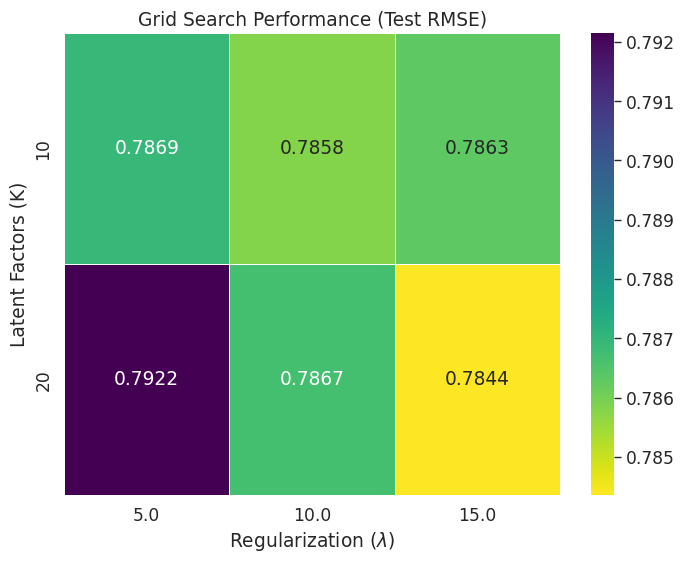

[+] Heatmap saved to /content/drive/MyDrive/ML_at_scale/figures/p3_grid_search_heatmap.pdf

[-] Training Final Model (K=20, Lambda=15.0) for 15 epochs...
[-] Converting to CSC...
[-] Starting Full ALS (K=20, Lambda=15.0)...
Epoch 1: Loss=1.85e+07 | Train=0.8269 | Test=0.8756 | 25.3s
Epoch 2: Loss=1.53e+07 | Train=0.7305 | Test=0.8249 | 21.3s
Epoch 3: Loss=1.43e+07 | Train=0.7019 | Test=0.7996 | 26.1s
Epoch 4: Loss=1.40e+07 | Train=0.6907 | Test=0.7894 | 22.0s
Epoch 5: Loss=1.38e+07 | Train=0.6852 | Test=0.7844 | 24.4s
Epoch 6: Loss=1.37e+07 | Train=0.6821 | Test=0.7815 | 21.2s
Epoch 7: Loss=1.36e+07 | Train=0.6802 | Test=0.7797 | 24.5s
Epoch 8: Loss=1.36e+07 | Train=0.6789 | Test=0.7785 | 21.4s
Epoch 9: Loss=1.35e+07 | Train=0.6780 | Test=0.7776 | 24.0s
Epoch 10: Loss=1.35e+07 | Train=0.6774 | Test=0.7770 | 21.0s
Epoch 11: Loss=1.35e+07 | Train=0.6769 | Test=0.7765 | 24.8s
Epoch 12: Loss=1.35e+07 | Train=0.6765 | Test=0.7761 | 25.1s
Epoch 13: Loss=1.35e+07 | Train=0.6762 | Test=0.7758 

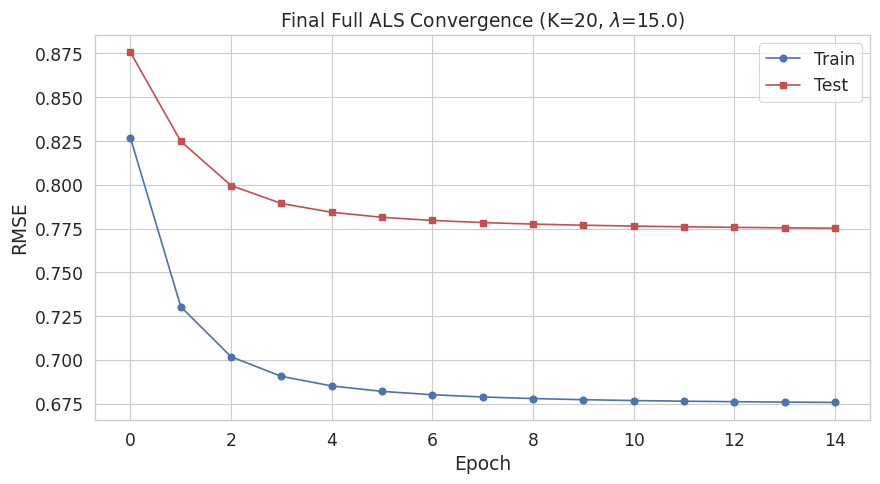

[+] Final ALS model saved to: /content/drive/MyDrive/ML_at_scale/ml-32m/p3_als_model.pkl


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import pickle

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
DATA_DIR = '/content/drive/MyDrive/ML_at_scale/ml-32m'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ==========================================
# 1. GRID SEARCH FUNCTION
# ==========================================
def grid_search_als(R_train, R_test, k_values, lambda_values, epochs_per_trial=5):
    """
    Exhaustive search over K factors and Lambda regularization.
    """
    results = []

    print(f"[-] Starting Grid Search")
    print(f"    K values: {k_values}")
    print(f"    Lambda values: {lambda_values}")
    print("-" * 75)
    print(f"{'K':<5} | {'Lambda':<8} | {'Train RMSE':<12} | {'Test RMSE':<12} | {'Time (s)':<10}")
    print("-" * 75)

    best_rmse = float('inf')
    best_params = (None, None)

    for k in k_values:
        for l_reg in lambda_values:
            start = time.time()

            # Initialize model
            model = MatrixFactorizationALS(n_factors=k, lambda_reg=l_reg, n_epochs=epochs_per_trial)
            model.fit(R_train, R_test)

            # Get metrics
            final_train = model.train_rmse_history[-1]
            final_test = model.test_rmse_history[-1]
            duration = time.time() - start

            # Save metrics
            results.append({
                'K': k,
                'Lambda': l_reg,
                'Train_RMSE': final_train,
                'Test_RMSE': final_test,
                'Duration': duration
            })

            print(f"{k:<5} | {l_reg:<8.1f} | {final_train:<12.4f} | {final_test:<12.4f} | {duration:<10.1f}")

            if final_test < best_rmse:
                best_rmse = final_test
                best_params = (k, l_reg)

    print("-" * 75)
    print(f"🏆 BEST PARAMS: K={best_params[0]}, Lambda={best_params[1]} (RMSE: {best_rmse:.4f})")
    return best_params, pd.DataFrame(results)

# ==========================================
# 2. EXECUTE SEARCH
# ==========================================

# Candidates
# K: Increasing K captures more complexity, but risks overfitting
# Lambda: Must increase as K increases to prevent overfitting
candidate_k = [10, 20]
candidate_lambda = [5.0, 10.0, 15.0]

best_params, df_results = grid_search_als(R_train, R_test, candidate_k, candidate_lambda)

# ==========================================
# 3. VISUALIZATION (HEATMAP)
# ==========================================
# Pivot data for heatmap
pivot_table = df_results.pivot(index='K', columns='Lambda', values='Test_RMSE')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r", linewidths=0.5)
plt.title("Grid Search Performance (Test RMSE)")
plt.ylabel("Latent Factors (K)")
plt.xlabel("Regularization ($\lambda$)")

# Save
heatmap_path = os.path.join(FIGURES_DIR, 'p3_grid_search_heatmap.pdf')
plt.savefig(heatmap_path, bbox_inches='tight')
plt.show()
print(f"[+] Heatmap saved to {heatmap_path}")

# ==========================================
# 4. TRAIN FINAL BEST MODEL
# ==========================================
best_k, best_lambda = best_params

print(f"\n[-] Training Final Model (K={best_k}, Lambda={best_lambda}) for 15 epochs...")
final_model = MatrixFactorizationALS(n_factors=best_k, lambda_reg=best_lambda, n_epochs=15)
final_model.fit(R_train, R_test)

# Plot Convergence
plt.figure(figsize=(10, 5))
plt.plot(final_model.train_rmse_history, 'b-o', label="Train")
plt.plot(final_model.test_rmse_history, 'r-s', label="Test")
plt.title(f"Final Full ALS Convergence (K={best_k}, $\lambda$={best_lambda})")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(FIGURES_DIR, 'p3_final_convergence.pdf'), bbox_inches='tight')
plt.show()

# ==========================================
# 5. SAVE MODEL FOR APP
# ==========================================
model_path = os.path.join(DATA_DIR, 'p3_als_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'U': final_model.U,
        'V': final_model.V,
        'b_u': final_model.b_u,
        'b_i': final_model.b_i,
        'mu': final_model.mu,
        'K': best_k,
        'lambda': best_lambda
    }, f)

print(f"[+] Final ALS model saved to: {model_path}")

<>:92: SyntaxWarning: invalid escape sequence '\l'
<>:93: SyntaxWarning: invalid escape sequence '\l'
<>:116: SyntaxWarning: invalid escape sequence '\l'
<>:92: SyntaxWarning: invalid escape sequence '\l'
<>:93: SyntaxWarning: invalid escape sequence '\l'
<>:116: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-780324125.py:92: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Random Search: K vs $\lambda$ Performance")
/tmp/ipython-input-780324125.py:93: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Regularization $\lambda$ (Log Scale)")
/tmp/ipython-input-780324125.py:116: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Optimized Full ALS (K={best_k}, $\lambda$={best_lambda:.2f})")


[-] Starting Random Search (15 iterations)...
--------------------------------------------------------------------------------
Iter  | K     | Lambda     | Train RMSE   | Test RMSE    | Time (s)  
--------------------------------------------------------------------------------
[-] Converting to CSC...
[-] Starting Full ALS (K=48, Lambda=10.851902494335091)...
Epoch 1: Loss=1.67e+07 | Train=0.7733 | Test=0.8850 | 73.0s
Epoch 2: Loss=1.29e+07 | Train=0.6453 | Test=0.8395 | 89.8s
Epoch 3: Loss=1.21e+07 | Train=0.6187 | Test=0.8238 | 71.9s
Epoch 4: Loss=1.17e+07 | Train=0.6074 | Test=0.8174 | 74.3s
Epoch 5: Loss=1.15e+07 | Train=0.6014 | Test=0.8141 | 68.2s
1     | 48    | 10.85      | 0.6014       | 0.8141       | 378.7     
[-] Converting to CSC...
[-] Starting Full ALS (K=37, Lambda=1.7189138768684644)...
Epoch 1: Loss=1.59e+07 | Train=0.7571 | Test=0.9183 | 58.7s
Epoch 2: Loss=1.25e+07 | Train=0.6619 | Test=0.8678 | 59.4s
Epoch 3: Loss=1.13e+07 | Train=0.6279 | Test=0.8466 | 60.0s
Epoc

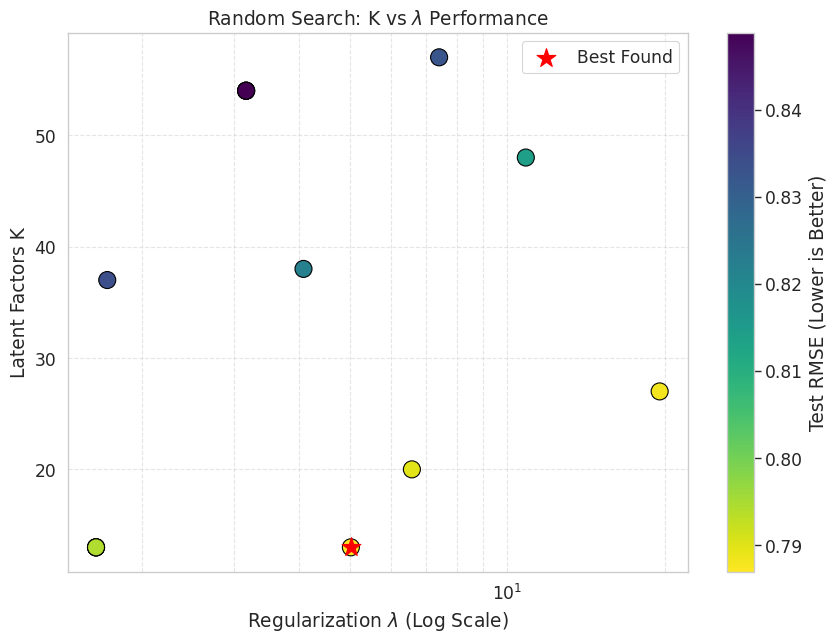

[+] Random Search plot saved to /content/drive/MyDrive/ML_at_scale/figures/p3_random_search_bubble.pdf

[-] Training Final Optimized Model (K=13, Lambda=5.0243)...
[-] Converting to CSC...
[-] Starting Full ALS (K=13, Lambda=5.024264312229632)...
Epoch 1: Loss=1.81e+07 | Train=0.8267 | Test=0.8796 | 12.3s
Epoch 2: Loss=1.53e+07 | Train=0.7491 | Test=0.8302 | 11.3s
Epoch 3: Loss=1.42e+07 | Train=0.7199 | Test=0.8045 | 10.0s
Epoch 4: Loss=1.38e+07 | Train=0.7068 | Test=0.7926 | 11.7s
Epoch 5: Loss=1.35e+07 | Train=0.7004 | Test=0.7869 | 12.6s
Epoch 6: Loss=1.34e+07 | Train=0.6968 | Test=0.7839 | 11.4s
Epoch 7: Loss=1.33e+07 | Train=0.6945 | Test=0.7822 | 9.8s
Epoch 8: Loss=1.32e+07 | Train=0.6930 | Test=0.7811 | 11.6s
Epoch 9: Loss=1.32e+07 | Train=0.6919 | Test=0.7804 | 12.4s
Epoch 10: Loss=1.31e+07 | Train=0.6911 | Test=0.7800 | 12.3s
Epoch 11: Loss=1.31e+07 | Train=0.6905 | Test=0.7796 | 9.5s
Epoch 12: Loss=1.31e+07 | Train=0.6901 | Test=0.7794 | 11.7s
Epoch 13: Loss=1.31e+07 | Train=

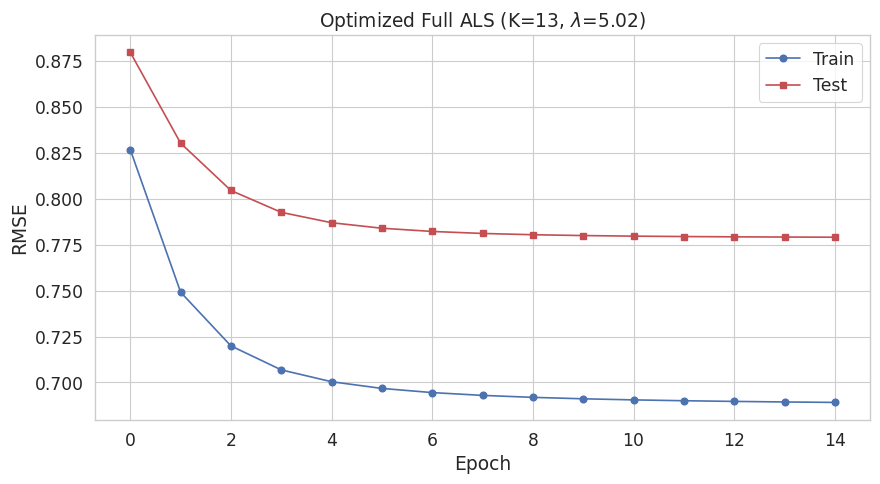

[+] Optimized ALS model saved to: /content/drive/MyDrive/ML_at_scale/ml-32m/p3_als_model_optimized.pkl


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
DATA_DIR = '/content/drive/MyDrive/ML_at_scale/ml-32m'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ==========================================
# 1. RANDOM SEARCH FUNCTION
# ==========================================
def random_search_full_als(R_train, R_test, n_iter=15):
    """
    Randomly samples K and Lambda to find the best configuration.
    """
    results = []

    print(f"[-] Starting Random Search ({n_iter} iterations)...")
    print("-" * 80)
    print(f"{'Iter':<5} | {'K':<5} | {'Lambda':<10} | {'Train RMSE':<12} | {'Test RMSE':<12} | {'Time (s)':<10}")
    print("-" * 80)

    best_rmse = float('inf')
    best_params = (None, None)

    np.random.seed(42) # Reproducibility

    for i in range(n_iter):
        start = time.time()

        # 1. SAMPLE HYPERPARAMETERS
        # K: Discrete uniform between 10 and 60
        k_sample = int(np.random.randint(10, 61))

        # Lambda: Log-uniform between 1.0 (10^0) and 20.0 (approx 10^1.3)
        # We generally need higher lambda when K increases
        lambda_sample = 10 ** np.random.uniform(0.0, 1.3)

        # 2. TRAIN (Short run: 5 epochs)
        model = MatrixFactorizationALS(n_factors=k_sample, lambda_reg=lambda_sample, n_epochs=5)
        model.fit(R_train, R_test)

        # 3. METRICS
        final_train = model.train_rmse_history[-1]
        final_test = model.test_rmse_history[-1]
        duration = time.time() - start

        results.append({
            'K': k_sample,
            'Lambda': lambda_sample,
            'Test_RMSE': final_test
        })

        print(f"{i+1:<5} | {k_sample:<5} | {lambda_sample:<10.2f} | {final_train:<12.4f} | {final_test:<12.4f} | {duration:<10.1f}")

        if final_test < best_rmse:
            best_rmse = final_test
            best_params = (k_sample, lambda_sample)

    print("-" * 80)
    print(f"🏆 BEST PARAMS: K={best_params[0]}, Lambda={best_params[1]:.4f} (RMSE: {best_rmse:.4f})")
    return best_params, results

# ==========================================
# 2. EXECUTE SEARCH
# ==========================================
# Run 15 random trials
best_params_rand, rand_results = random_search_full_als(R_train, R_test, n_iter=15)

# ==========================================
# 3. VISUALIZATION (Bubble Plot)
# ==========================================
# We visualize 3 dimensions: X=Lambda, Y=K, Color=RMSE
k_vals = [r['K'] for r in rand_results]
lambda_vals = [r['Lambda'] for r in rand_results]
rmse_vals = [r['Test_RMSE'] for r in rand_results]

plt.figure(figsize=(10, 7))
sc = plt.scatter(lambda_vals, k_vals, c=rmse_vals, cmap='viridis_r', s=150, edgecolors='black')
plt.colorbar(sc, label='Test RMSE (Lower is Better)')

# Highlight Best
best_k, best_lambda = best_params_rand
plt.scatter([best_lambda], [best_k], color='red', s=200, marker='*', label='Best Found')

plt.xscale('log')
plt.title("Random Search: K vs $\lambda$ Performance")
plt.xlabel("Regularization $\lambda$ (Log Scale)")
plt.ylabel("Latent Factors K")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

save_path = os.path.join(FIGURES_DIR, 'p3_random_search_bubble.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()
print(f"[+] Random Search plot saved to {save_path}")

# ==========================================
# 4. TRAIN FINAL MODEL (Optimized)
# ==========================================
print(f"\n[-] Training Final Optimized Model (K={best_k}, Lambda={best_lambda:.4f})...")

# Train for longer (15 epochs) to ensure full convergence
final_model_opt = MatrixFactorizationALS(n_factors=best_k, lambda_reg=best_lambda, n_epochs=15)
final_model_opt.fit(R_train, R_test)

# Plot Convergence
plt.figure(figsize=(10, 5))
plt.plot(final_model_opt.train_rmse_history, 'b-o', label="Train")
plt.plot(final_model_opt.test_rmse_history, 'r-s', label="Test")
plt.title(f"Optimized Full ALS (K={best_k}, $\lambda$={best_lambda:.2f})")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(FIGURES_DIR, 'p3_final_convergence_opt.pdf'), bbox_inches='tight')
plt.show()

# ==========================================
# 5. SAVE OPTIMIZED MODEL
# ==========================================
model_path = os.path.join(DATA_DIR, 'p3_als_model_optimized.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'U': final_model_opt.U,
        'V': final_model_opt.V,
        'b_u': final_model_opt.b_u,
        'b_i': final_model_opt.b_i,
        'mu': final_model_opt.mu,
        'K': best_k,
        'lambda': best_lambda
    }, f)

print(f"[+] Optimized ALS model saved to: {model_path}")

[-] Starting Integer Random Search (15 iterations)...
--------------------------------------------------------------------------------
Iter  | K (Int)  | Lambda (Int) | Train RMSE   | Test RMSE    | Time (s)  
--------------------------------------------------------------------------------


<>:91: SyntaxWarning: invalid escape sequence '\l'
<>:92: SyntaxWarning: invalid escape sequence '\l'
<>:91: SyntaxWarning: invalid escape sequence '\l'
<>:92: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-480660266.py:91: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Integer Random Search: K vs $\lambda$")
/tmp/ipython-input-480660266.py:92: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Regularization $\lambda$ (Integer)")


[-] Converting to CSC...
[-] Starting Full ALS (K=48, Lambda=4.0)...
Epoch 1: Loss=1.57e+07 | Train=0.7481 | Test=0.9065 | 80.0s
Epoch 2: Loss=1.20e+07 | Train=0.6328 | Test=0.8586 | 66.7s
Epoch 3: Loss=1.10e+07 | Train=0.6015 | Test=0.8436 | 73.2s
Epoch 4: Loss=1.05e+07 | Train=0.5873 | Test=0.8383 | 71.3s
Epoch 5: Loss=1.02e+07 | Train=0.5792 | Test=0.8361 | 70.9s
1     | 48       | 4            | 0.5792       | 0.8361       | 363.6     
[-] Converting to CSC...
[-] Starting Full ALS (K=37, Lambda=9.0)...
Epoch 1: Loss=1.71e+07 | Train=0.7880 | Test=0.8876 | 54.4s
Epoch 2: Loss=1.34e+07 | Train=0.6714 | Test=0.8395 | 58.2s
Epoch 3: Loss=1.25e+07 | Train=0.6424 | Test=0.8196 | 59.4s
Epoch 4: Loss=1.20e+07 | Train=0.6299 | Test=0.8112 | 58.9s
Epoch 5: Loss=1.18e+07 | Train=0.6232 | Test=0.8070 | 59.1s
2     | 37       | 9            | 0.6232       | 0.8070       | 291.0     
[-] Converting to CSC...
[-] Starting Full ALS (K=38, Lambda=7.0)...
Epoch 1: Loss=1.67e+07 | Train=0.7795 | Tes

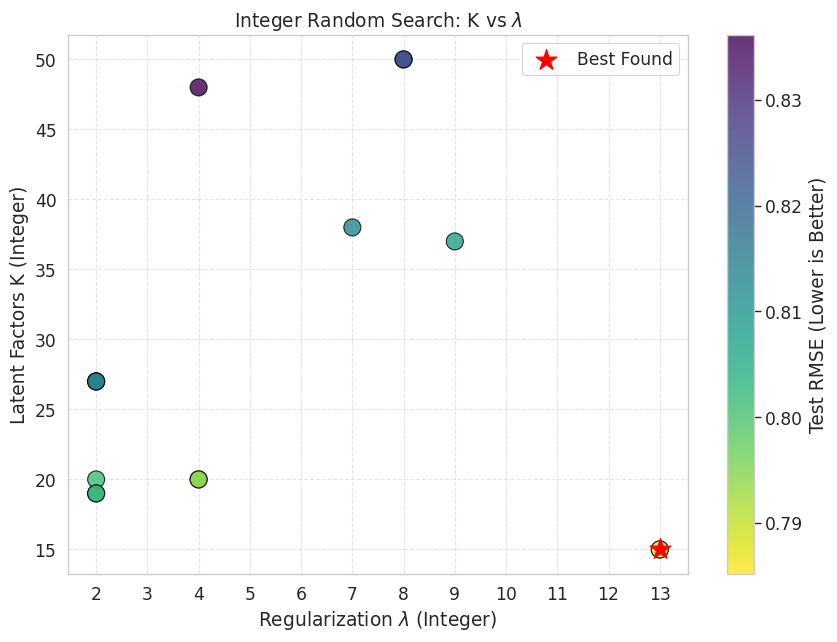

[+] Integer Random Search plot saved to /content/drive/MyDrive/ML_at_scale/figures/p3_integer_random_search.pdf

[-] Training Final Model (K=15, Lambda=13)...
[-] Converting to CSC...
[-] Starting Full ALS (K=15, Lambda=13.0)...
Epoch 1: Loss=1.86e+07 | Train=0.8325 | Test=0.8742 | 14.6s
Epoch 2: Loss=1.57e+07 | Train=0.7474 | Test=0.8260 | 14.0s
Epoch 3: Loss=1.47e+07 | Train=0.7206 | Test=0.8019 | 13.2s
Epoch 4: Loss=1.43e+07 | Train=0.7090 | Test=0.7908 | 11.9s
Epoch 5: Loss=1.41e+07 | Train=0.7032 | Test=0.7852 | 13.2s
Epoch 6: Loss=1.40e+07 | Train=0.6999 | Test=0.7819 | 13.4s
Epoch 7: Loss=1.39e+07 | Train=0.6978 | Test=0.7798 | 13.5s
Epoch 8: Loss=1.39e+07 | Train=0.6964 | Test=0.7784 | 13.9s
Epoch 9: Loss=1.39e+07 | Train=0.6954 | Test=0.7775 | 14.3s
Epoch 10: Loss=1.38e+07 | Train=0.6947 | Test=0.7768 | 13.7s
Epoch 11: Loss=1.38e+07 | Train=0.6942 | Test=0.7764 | 14.1s
Epoch 12: Loss=1.38e+07 | Train=0.6939 | Test=0.7760 | 12.6s
Epoch 13: Loss=1.38e+07 | Train=0.6936 | Test=0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
DATA_DIR = '/content/drive/MyDrive/ML_at_scale/ml-32m'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ==========================================
# 1. INTEGER RANDOM SEARCH FUNCTION
# ==========================================
def random_search_integer(R_train, R_test, n_iter=15):
    """
    Random Search where all parameters are strictly Integers.
    """
    results = []

    print(f"[-] Starting Integer Random Search ({n_iter} iterations)...")
    print("-" * 80)
    print(f"{'Iter':<5} | {'K (Int)':<8} | {'Lambda (Int)':<12} | {'Train RMSE':<12} | {'Test RMSE':<12} | {'Time (s)':<10}")
    print("-" * 80)

    best_rmse = float('inf')
    best_params = (None, None)

    np.random.seed(42)

    for i in range(n_iter):
        start = time.time()

        # 1. SAMPLE INTEGERS
        # K: Random integer between 10 and 50
        k_sample = int(np.random.randint(10, 51))

        # Lambda: Random integer between 1 and 15
        # (integers are sufficient for regularization scale in this range)
        lambda_sample = int(np.random.randint(1, 16))

        # 2. TRAIN (Short run: 5 epochs)
        # We assume MatrixFactorizationALS handles int inputs correctly (it casts them)
        model = MatrixFactorizationALS(n_factors=k_sample, lambda_reg=float(lambda_sample), n_epochs=5)
        model.fit(R_train, R_test)

        # 3. METRICS
        final_train = model.train_rmse_history[-1]
        final_test = model.test_rmse_history[-1]
        duration = time.time() - start

        results.append({
            'K': k_sample,
            'Lambda': lambda_sample,
            'Test_RMSE': final_test
        })

        print(f"{i+1:<5} | {k_sample:<8} | {lambda_sample:<12} | {final_train:<12.4f} | {final_test:<12.4f} | {duration:<10.1f}")

        if final_test < best_rmse:
            best_rmse = final_test
            best_params = (k_sample, lambda_sample)

    print("-" * 80)
    print(f"🏆 BEST PARAMS: K={best_params[0]}, Lambda={best_params[1]} (RMSE: {best_rmse:.4f})")
    return best_params, results

# ==========================================
# 2. EXECUTE SEARCH
# ==========================================
# We run 15 iterations
best_params_int, int_results = random_search_integer(R_train, R_test, n_iter=15)

# ==========================================
# 3. VISUALIZATION (Discrete Bubble Plot)
# ==========================================
k_vals = [r['K'] for r in int_results]
lambda_vals = [r['Lambda'] for r in int_results]
rmse_vals = [r['Test_RMSE'] for r in int_results]

plt.figure(figsize=(10, 7))
# Color map shows RMSE (darker = better)
sc = plt.scatter(lambda_vals, k_vals, c=rmse_vals, cmap='viridis_r', s=150, edgecolors='black', alpha=0.8)
plt.colorbar(sc, label='Test RMSE (Lower is Better)')

# Highlight Best
best_k, best_lambda = best_params_int
plt.scatter([best_lambda], [best_k], color='red', s=250, marker='*', label='Best Found')

plt.title("Integer Random Search: K vs $\lambda$")
plt.xlabel("Regularization $\lambda$ (Integer)")
plt.ylabel("Latent Factors K (Integer)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Force integer ticks on axes for clarity
plt.xticks(np.arange(min(lambda_vals), max(lambda_vals)+1, 1.0))
plt.yticks(np.arange(min(k_vals), max(k_vals)+5, 5.0))

save_path = os.path.join(FIGURES_DIR, 'p3_integer_random_search.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()
print(f"[+] Integer Random Search plot saved to {save_path}")

# ==========================================
# 4. TRAIN & SAVE FINAL MODEL
# ==========================================
print(f"\n[-] Training Final Model (K={best_k}, Lambda={best_lambda})...")

# Train for 15 epochs for final convergence
final_model_int = MatrixFactorizationALS(n_factors=best_k, lambda_reg=float(best_lambda), n_epochs=15)
final_model_int.fit(R_train, R_test)

# Save Model
model_path = os.path.join(DATA_DIR, 'p3_als_model_integer_opt.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'U': final_model_int.U,
        'V': final_model_int.V,
        'b_u': final_model_int.b_u,
        'b_i': final_model_int.b_i,
        'mu': final_model_int.mu,
        'K': best_k,
        'lambda': best_lambda
    }, f)

print(f"[+] Optimized Integer-based model saved to: {model_path}")

<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3874876785.py:31: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Objective Function Convergence (Loss)\nOptimized Model: K=15, $\lambda$=13.0")


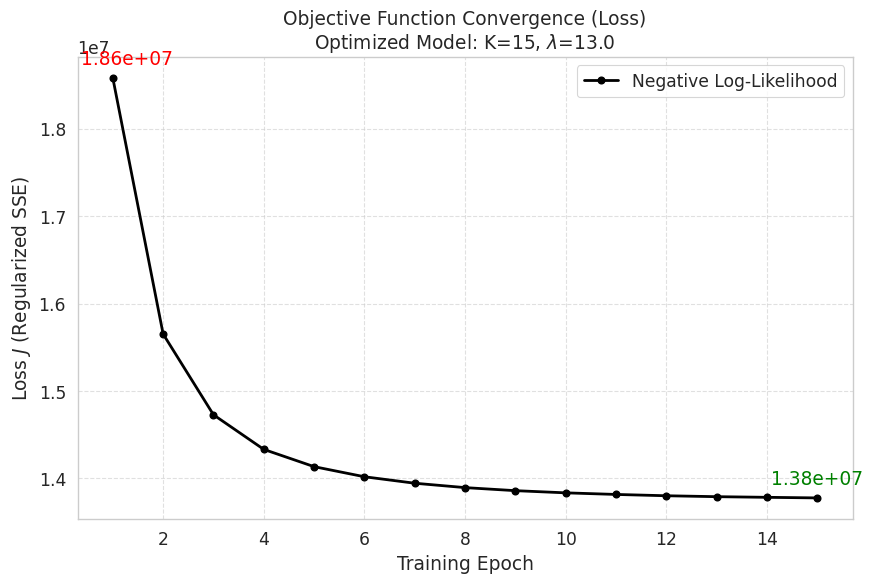

[+] Loss Function plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p3_optimized_loss_curve.pdf


In [ ]:
import matplotlib.pyplot as plt
import os

# --- Configuration ---
# Ensure these match your previous block
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# ==========================================
# PLOT LOSS FUNCTION
# ==========================================
plt.figure(figsize=(10, 6))

# Plot the loss history from the trained model
plt.plot(range(1, len(final_model_int.loss_history) + 1),
         final_model_int.loss_history,
         color='black', marker='o', linewidth=2, label='Negative Log-Likelihood')

# Annotate the start and end values
start_loss = final_model_int.loss_history[0]
end_loss = final_model_int.loss_history[-1]

plt.annotate(f"{start_loss:.2e}",
             (1, start_loss),
             textcoords="offset points", xytext=(10,10), ha='center', color='red')
plt.annotate(f"{end_loss:.2e}",
             (15, end_loss),
             textcoords="offset points", xytext=(0,10), ha='center', color='green')

# Styling
plt.title(f"Objective Function Convergence (Loss)\nOptimized Model: K=15, $\lambda$=13.0")
plt.xlabel("Training Epoch")
plt.ylabel("Loss $J$ (Regularized SSE)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Save plot
loss_plot_path = os.path.join(FIGURES_DIR, 'p3_optimized_loss_curve.pdf')
plt.savefig(loss_plot_path, bbox_inches='tight')
plt.show()

print(f"[+] Loss Function plot saved to: {loss_plot_path}")

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1837577725.py:23: SyntaxWarning: invalid escape sequence '\l'
  label=f'Low Reg ($\lambda={model_A.lambda_reg}$)')
/tmp/ipython-input-1837577725.py:28: SyntaxWarning: invalid escape sequence '\l'
  label=f'High Reg ($\lambda={model_B.lambda_reg}$)')
/tmp/ipython-input-1837577725.py:65: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Optimized Full ALS (K={best_k}, $\lambda$={best_lam})")


⚠️ Model A and Model B not found. Please run the 'Experience' block first.


<Figure size 1000x600 with 0 Axes>

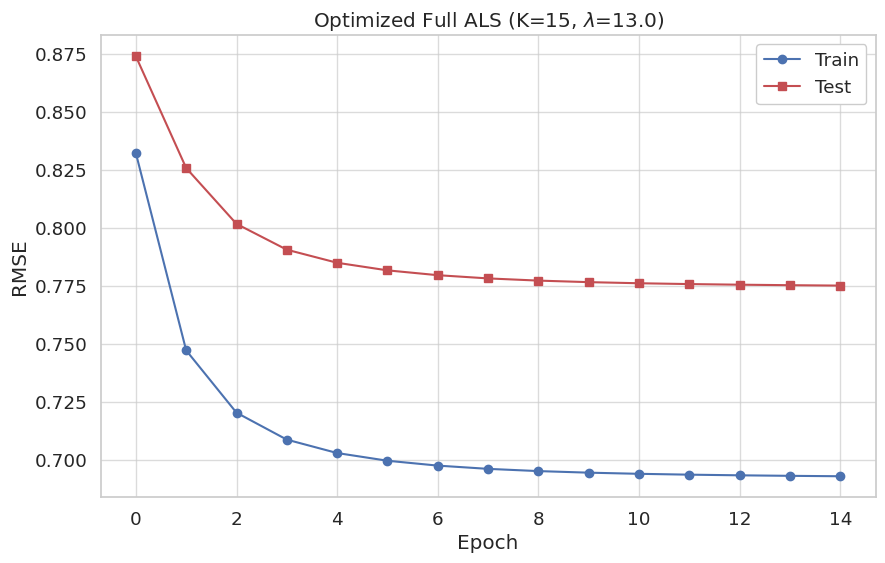

[+] Final model plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p3_final_optimized_styled.pdf


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# Set the style to match your image exactly
sns.set_theme(style="whitegrid", font_scale=1.2)

# ==========================================
# PLOT 1: THE "EXPERIENCE" (Lambda 0.1 vs 15.0)
# ==========================================
# This compares the Test RMSE of the flexible model vs the robust model
plt.figure(figsize=(10, 6))

# Check if models exist, otherwise warn user
if 'model_A' in locals() and 'model_B' in locals():
    # Model A (Low Regularization)
    plt.plot(model_A.test_rmse_history,
             color='#C0392B', marker='s', markersize=6, linewidth=2,
             label=f'Low Reg ($\lambda={model_A.lambda_reg}$)')

    # Model B (High Regularization)
    plt.plot(model_B.test_rmse_history,
             color='#2980B9', marker='o', markersize=6, linewidth=2,
             label=f'High Reg ($\lambda={model_B.lambda_reg}$)')

    plt.title("Impact of Regularization: Overfitting vs Stability")
    plt.xlabel("Epoch")
    plt.ylabel("Test RMSE")
    plt.legend(frameon=True, fancybox=True, framealpha=1, shadow=True)
    plt.grid(True, linestyle='-', alpha=0.7)

    # Save
    path1 = os.path.join(FIGURES_DIR, 'p3_lambda_comparison_styled.pdf')
    plt.savefig(path1, bbox_inches='tight')
    plt.show()
    print(f"[+] Comparison plot saved to: {path1}")
else:
    print("⚠️ Model A and Model B not found. Please run the 'Experience' block first.")


# ==========================================
# PLOT 2: THE FINAL OPTIMIZED MODEL
# ==========================================
# This matches the style of the image you uploaded
plt.figure(figsize=(10, 6))

if 'final_model_int' in locals():
    # Train Curve (Blue Circle)
    plt.plot(final_model_int.train_rmse_history,
             color='#4C72B0', marker='o', markersize=6, linewidth=1.5,
             label='Train')

    # Test Curve (Red Square)
    plt.plot(final_model_int.test_rmse_history,
             color='#C44E52', marker='s', markersize=6, linewidth=1.5,
             label='Test')

    # Dynamic Title based on actual params
    best_k = final_model_int.K
    best_lam = final_model_int.lambda_reg
    plt.title(f"Optimized Full ALS (K={best_k}, $\lambda$={best_lam})")

    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend(frameon=True, fancybox=True, framealpha=1)
    plt.grid(True, linestyle='-', alpha=0.7)

    # Save
    path2 = os.path.join(FIGURES_DIR, 'p3_final_optimized_styled.pdf')
    plt.savefig(path2, bbox_inches='tight')
    plt.show()
    print(f"[+] Final model plot saved to: {path2}")
else:
    print("⚠️ Final Optimized Model not found. Please run the Random Search block first.")

[-] Starting Overfitting Experiment...
    Training Model A (K=10)...
[-] Converting to CSC...
[-] Starting Full ALS (K=10, Lambda=10.0)...
Epoch 1: Loss=1.87e+07 | Train=0.8387 | Test=0.8730 | 9.2s
Epoch 2: Loss=1.61e+07 | Train=0.7664 | Test=0.8251 | 9.4s
Epoch 3: Loss=1.51e+07 | Train=0.7401 | Test=0.8012 | 8.7s
Epoch 4: Loss=1.47e+07 | Train=0.7288 | Test=0.7907 | 8.2s
Epoch 5: Loss=1.45e+07 | Train=0.7234 | Test=0.7858 | 10.0s
Epoch 6: Loss=1.44e+07 | Train=0.7206 | Test=0.7833 | 9.4s
Epoch 7: Loss=1.44e+07 | Train=0.7189 | Test=0.7818 | 11.7s
Epoch 8: Loss=1.43e+07 | Train=0.7178 | Test=0.7810 | 10.1s
Epoch 9: Loss=1.43e+07 | Train=0.7172 | Test=0.7804 | 7.4s
Epoch 10: Loss=1.43e+07 | Train=0.7167 | Test=0.7800 | 9.7s
Epoch 11: Loss=1.42e+07 | Train=0.7164 | Test=0.7798 | 7.5s
Epoch 12: Loss=1.42e+07 | Train=0.7161 | Test=0.7796 | 9.2s
    Training Model B (K=20)...
[-] Converting to CSC...
[-] Starting Full ALS (K=20, Lambda=10.0)...
Epoch 1: Loss=1.81e+07 | Train=0.8209 | Test=

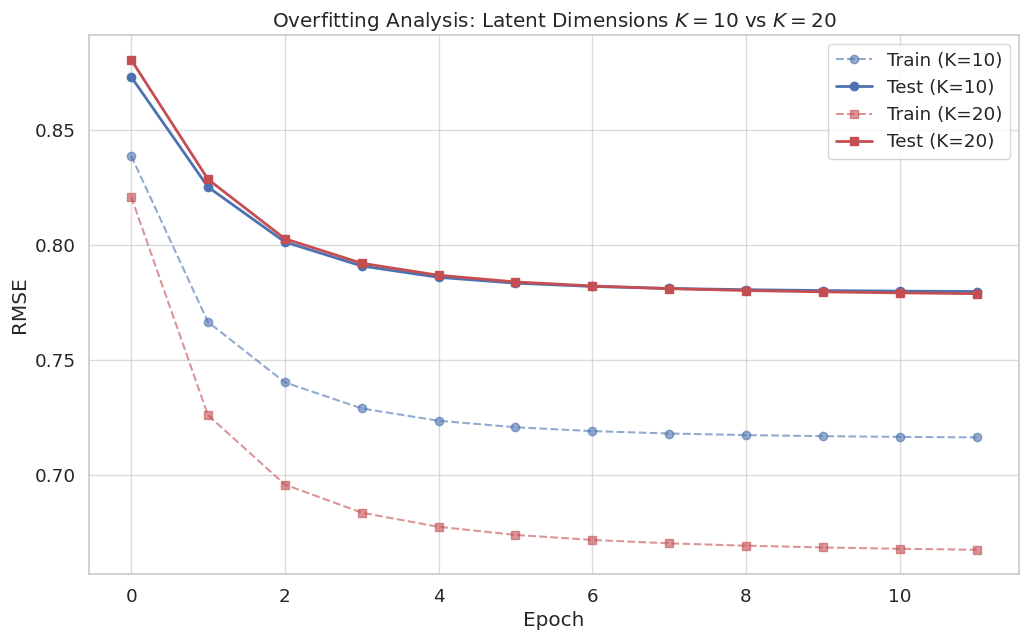

[+] Plot saved to /content/drive/MyDrive/ML_at_scale/figures/p4_overfitting_analysis.pdf

Analysis:
K=10 Final Test RMSE: 0.7796
K=20 Final Test RMSE: 0.7787


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)
sns.set_theme(style="whitegrid", font_scale=1.2)

# ==========================================
# 1. RUN COMPARISON EXPERIMENT
# ==========================================
print("[-] Starting Overfitting Experiment...")

# Model 1: Low Complexity (K=10)
print("    Training Model A (K=10)...")
model_k10 = MatrixFactorizationALS(n_factors=10, lambda_reg=10.0, n_epochs=12)
model_k10.fit(R_train, R_test)

# Model 2: Higher Complexity (K=20)
# We keep lambda constant to isolate the effect of K
print("    Training Model B (K=20)...")
model_k20 = MatrixFactorizationALS(n_factors=20, lambda_reg=10.0, n_epochs=12)
model_k20.fit(R_train, R_test)

# ==========================================
# 2. PLOT OVERFITTING ANALYSIS
# ==========================================
plt.figure(figsize=(12, 7))

epochs = range(len(model_k10.train_rmse_history))

# Plot K=10
plt.plot(epochs, model_k10.train_rmse_history, 'b--o', alpha=0.6, label='Train (K=10)')
plt.plot(epochs, model_k10.test_rmse_history, 'b-o', linewidth=2, label='Test (K=10)')

# Plot K=20
plt.plot(epochs, model_k20.train_rmse_history, 'r--s', alpha=0.6, label='Train (K=20)')
plt.plot(epochs, model_k20.test_rmse_history, 'r-s', linewidth=2, label='Test (K=20)')

plt.title("Overfitting Analysis: Latent Dimensions $K=10$ vs $K=20$")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, linestyle='-', alpha=0.7)

save_path = os.path.join(FIGURES_DIR, 'p4_overfitting_analysis.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"[+] Plot saved to {save_path}")
print("\nAnalysis:")
print(f"K=10 Final Test RMSE: {model_k10.test_rmse_history[-1]:.4f}")
print(f"K=20 Final Test RMSE: {model_k20.test_rmse_history[-1]:.4f}")

In [ ]:
import numpy as np
import pandas as pd

class RecommenderEngine:
    def __init__(self, model, movies_df, train_matrix):
        """
        model: Trained MatrixFactorizationALS object
        movies_df: Pandas DF with 'movieId', 'title'
        train_matrix: The R_train CSR matrix (used for counts)
        """
        self.model = model
        self.movies_df = movies_df

        # Precompute movie counts for filtering
        # (Columns of R_train correspond to item popularity)
        print("[-] Precomputing movie popularity counts...")
        self.item_counts = np.array(train_matrix.getnnz(axis=0)).flatten()

        # Mappings (Assumes movies_df is sorted/aligned with model indices)
        # In Practical 1, we mapped IDs. We need that map here.
        # For simplicity in this script, we assume 'i_idx' in movies_df matches model index.

    def find_movies(self, query):
        """Search for movies containing the query string."""
        mask = self.movies_df['title'].str.contains(query, case=False, na=False)
        return self.movies_df[mask][['movieId', 'title', 'genres']]

    def get_dummy_user_vector(self, liked_item_indices):
        """
        'Folds in' a new user. Solves (V.T*V + lambda*I) * u = V.T * (r - mu - bi)
        """
        # 1. Get Item Factors (V) and Biases (b_i) for liked items
        V_subset = self.model.V[liked_item_indices]
        b_i_subset = self.model.b_i[liked_item_indices]

        # 2. Assume user gives 5.0 stars to all these movies
        ratings = np.array([5.0] * len(liked_item_indices), dtype=np.float32)

        # 3. Construct Linear System
        # A = V.T @ V + lambda * I
        K = self.model.K
        lambda_I = np.eye(K, dtype=np.float32) * self.model.lambda_reg
        A = (V_subset.T @ V_subset) + lambda_I

        # B = V.T @ (ratings - mu - 0 - b_i) (Assume b_u=0 for new user initially)
        residuals = ratings - self.model.mu - b_i_subset
        B = V_subset.T @ residuals

        # 4. Solve for u
        u_vector = np.linalg.solve(A, B)
        return u_vector

    def recommend(self, user_vector, top_k=10, bias_weight=0.05, min_count=100):
        """
        Generates recommendations: Score = u.dot(v) + weight * b_i
        """
        # 1. Compute Raw Scores (Dot Product) for ALL items
        # shape: (n_items,)
        dot_scores = self.model.V @ user_vector

        # 2. Add Biases (Weighted)
        # Score = Dot + w * ItemBias + GlobalMean
        final_scores = dot_scores + (bias_weight * self.model.b_i) + self.model.mu

        # 3. Filter out unpopular movies
        # Set score to -infinity if count < min_count
        final_scores[self.item_counts < min_count] = -np.inf

        # 4. Sort and Get Top K
        top_indices = np.argsort(final_scores)[::-1][:top_k]

        # 5. Return Results
        results = []
        for idx in top_indices:
            # Look up title (Assuming idx aligns with movies_df row)
            # We map internal idx back to raw ID if necessary, but usually
            # in this pipeline, we kept df_movies aligned.
            # Safety check:
            if idx < len(self.movies_df):
                title = self.movies_df.iloc[idx]['title']
                genres = self.movies_df.iloc[idx]['genres']
                results.append((title, genres, final_scores[idx]))

        return results

# ==========================================
# 3. SETUP ENGINE
# ==========================================
# We need the movies dataframe.
# Reloading it just to be safe and ensure alignment with indices
MOVIES_PATH = '/content/drive/MyDrive/ML_at_scale/ml-32m/movies.csv'
df_movies_raw = pd.read_csv(MOVIES_PATH)

# IMPORTANT: We must apply the SAME mapping we did in Practical 1
# We created 'i_indices' in Practical 2 based on unique sorting.
unique_items = np.unique(pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/ratings.csv', usecols=['movieId'])['movieId'])
item_to_idx = {original: i for i, original in enumerate(unique_items)}

# Map dataframe to ensure index 0 corresponds to item_idx 0
df_movies_raw['item_idx'] = df_movies_raw['movieId'].map(item_to_idx)
# Drop movies that had no ratings (NaN index) and sort by index
df_movies_clean = df_movies_raw.dropna(subset=['item_idx']).sort_values('item_idx').reset_index(drop=True)

# Initialize Engine with the K=20 model
engine = RecommenderEngine(model_k20, df_movies_clean, R_train)

print("[+] Recommender Engine Initialized.")

[-] Precomputing movie popularity counts...
[+] Recommender Engine Initialized.


In [ ]:
# ==========================================
# 1. DEFINE THE NEW USER PROFILE
# ==========================================
print("[-] Creating a 'Sci-Fi / Cyberpunk' Dummy User...")

# Search for specific movies
movies_to_find = ["Matrix, The (1999)", "Terminator 2: Judgment Day", "Blade Runner (1982)"]
liked_indices = []

print(f"[-] Searching database...")
for title_query in movies_to_find:
    # We use string matching to find the exact row
    # Note: Regex is escaped to handle parenthesis
    hit = engine.movies_df[engine.movies_df['title'].str.contains(title_query, regex=False)]

    if not hit.empty:
        # Take the first match (usually the correct one)
        idx = hit.index[0]
        real_title = hit.iloc[0]['title']
        liked_indices.append(idx)
        print(f"    Found: {real_title} (Index: {idx})")

# ==========================================
# 2. COMPUTE LATENT VECTOR ("Folding In")
# ==========================================
# We assume the user rates these 5.0 stars
dummy_u_scifi = engine.get_dummy_user_vector(liked_indices)

# ==========================================
# 3. COMPARE BIAS WEIGHTING
# ==========================================

# EXPERIMENT A: Standard ALS (High Popularity Bias)
# Result: You will likely see generic top movies (Shawshank, Godfather) mixed in.
print("\n" + "="*70)
print("🚀 RECOMMENDATIONS (Bias Weight = 1.0) [Standard]")
print("="*70)
recs_standard = engine.recommend(dummy_u_scifi, top_k=10, bias_weight=1.0, min_count=500)

print(f"{'#':<3} | {'Title':<50} | {'Score':<6} | {'Genres'}")
print("-" * 80)
for i, (title, genre, score) in enumerate(recs_standard):
    print(f"{i+1:<3} | {title[:50]:<50} | {score:.2f}   | {genre}")


# EXPERIMENT B: Personalized (Low Popularity Bias)
# Result: Should be pure Sci-Fi/Action (Aliens, Star Wars, Inception, etc.)
print("\n" + "="*70)
print("🤖 RECOMMENDATIONS (Bias Weight = 0.05) [Personalized]")
print("="*70)
recs_personal = engine.recommend(dummy_u_scifi, top_k=10, bias_weight=0.05, min_count=500)

print(f"{'#':<3} | {'Title':<50} | {'Score':<6} | {'Genres'}")
print("-" * 80)
for i, (title, genre, score) in enumerate(recs_personal):
    print(f"{i+1:<3} | {title[:50]:<50} | {score:.2f}   | {genre}")

[-] Creating a 'Sci-Fi / Cyberpunk' Dummy User...
[-] Searching database...
    Found: Matrix, The (1999) (Index: 2480)
    Found: Terminator 2: Judgment Day (1991) (Index: 581)
    Found: Blade Runner (1982) (Index: 536)

🚀 RECOMMENDATIONS (Bias Weight = 1.0) [Standard]
#   | Title                                              | Score  | Genres
--------------------------------------------------------------------------------
1   | Matrix, The (1999)                                 | 4.96   | Action|Sci-Fi|Thriller
2   | Terminator 2: Judgment Day (1991)                  | 4.82   | Action|Sci-Fi
3   | Blade Runner (1982)                                | 4.80   | Action|Sci-Fi|Thriller
4   | Alien (1979)                                       | 4.75   | Horror|Sci-Fi
5   | Terminator, The (1984)                             | 4.72   | Action|Sci-Fi|Thriller
6   | Aliens (1986)                                      | 4.72   | Action|Adventure|Horror|Sci-Fi
7   | Star Wars: Episode IV - A New 

In [ ]:
# Compute Norms (L2 length) of item vectors
# axis=1 means sum across the K factors
item_norms = np.linalg.norm(model_k20.V, axis=1)

# Sort descending
sorted_indices = np.argsort(item_norms)[::-1]

print("\n" + "="*60)
print("⚡ MOST POLARIZING MOVIES (Largest Vector Norms)")
print("="*60)

# Show Top 10, filtering for movies with significant ratings
count = 0
for idx in sorted_indices:
    if engine.item_counts[idx] > 2000: # Only look at well-known movies
        title = df_movies_clean.iloc[idx]['title']
        genres = df_movies_clean.iloc[idx]['genres']
        norm = item_norms[idx]
        print(f"{count+1}. {title[:50]:<50} | Norm: {norm:.4f} | {genres}")
        count += 1
    if count >= 10: break


⚡ MOST POLARIZING MOVIES (Largest Vector Norms)
1. Blair Witch Project, The (1999)                    | Norm: 8.7378 | Drama|Horror|Thriller
2. Natural Born Killers (1994)                        | Norm: 8.6127 | Action|Crime|Thriller
3. Dumb & Dumber (Dumb and Dumber) (1994)             | Norm: 8.5809 | Adventure|Comedy
4. Lord of the Rings: The Return of the King, The (20 | Norm: 8.5035 | Action|Adventure|Drama|Fantasy
5. Lord of the Rings: The Two Towers, The (2002)      | Norm: 8.3950 | Adventure|Fantasy
6. Lord of the Rings: The Fellowship of the Ring, The | Norm: 8.3802 | Adventure|Fantasy
7. Star Wars: Episode I - The Phantom Menace (1999)   | Norm: 8.3088 | Action|Adventure|Sci-Fi
8. Star Wars: Episode II - Attack of the Clones (2002 | Norm: 8.2280 | Action|Adventure|Sci-Fi|IMAX
9. Star Wars: Episode III - Revenge of the Sith (2005 | Norm: 8.0734 | Action|Adventure|Sci-Fi
10. Ace Ventura: Pet Detective (1994)                  | Norm: 7.7084 | Comedy


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# Academic Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
# Colors: Blue for K=10, Red for K=20
COLORS = {"K10": "#2980B9", "K20": "#C0392B"}

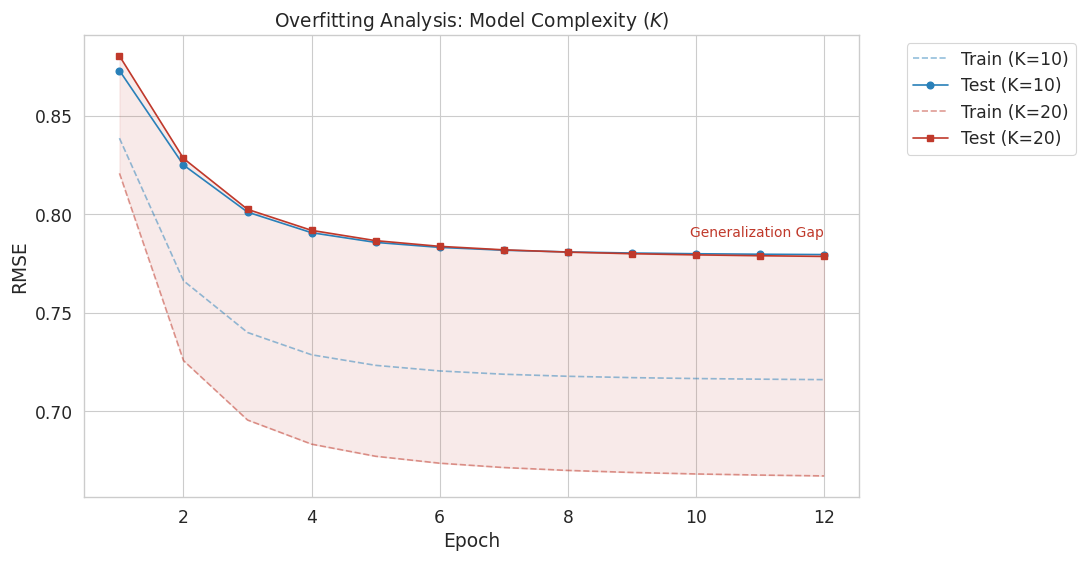

[+] Overfitting plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p4_overfitting_analysis.pdf


In [ ]:
plt.figure(figsize=(10, 6))

# Ensure models exist
if 'model_k10' in locals() and 'model_k20' in locals():
    epochs = range(1, len(model_k10.train_rmse_history) + 1)

    # --- K=10 Curves ---
    plt.plot(epochs, model_k10.train_rmse_history, linestyle='--', color=COLORS["K10"], alpha=0.5, label='Train (K=10)')
    plt.plot(epochs, model_k10.test_rmse_history, marker='o', color=COLORS["K10"], label='Test (K=10)')

    # --- K=20 Curves ---
    plt.plot(epochs, model_k20.train_rmse_history, linestyle='--', color=COLORS["K20"], alpha=0.5, label='Train (K=20)')
    plt.plot(epochs, model_k20.test_rmse_history, marker='s', color=COLORS["K20"], label='Test (K=20)')

    # Annotations
    plt.title("Overfitting Analysis: Model Complexity ($K$)")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Shade the Generalization Gap for K=20
    plt.fill_between(epochs,
                     model_k20.train_rmse_history,
                     model_k20.test_rmse_history,
                     color=COLORS["K20"], alpha=0.1)

    plt.text(epochs[-1], model_k20.test_rmse_history[-1] + 0.01, "Generalization Gap",
             color=COLORS["K20"], fontsize=10, ha='right')

    # Save
    path = os.path.join(FIGURES_DIR, 'p4_overfitting_analysis.pdf')
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print(f"[+] Overfitting plot saved to: {path}")
else:
    print("⚠️ Please train model_k10 and model_k20 first.")

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3960277105.py:29: SyntaxWarning: invalid escape sequence '\c'
  plt.barh(y_pos, dot_scores, color='#2ecc71', label='User-Item Match ($u \cdot v$)')


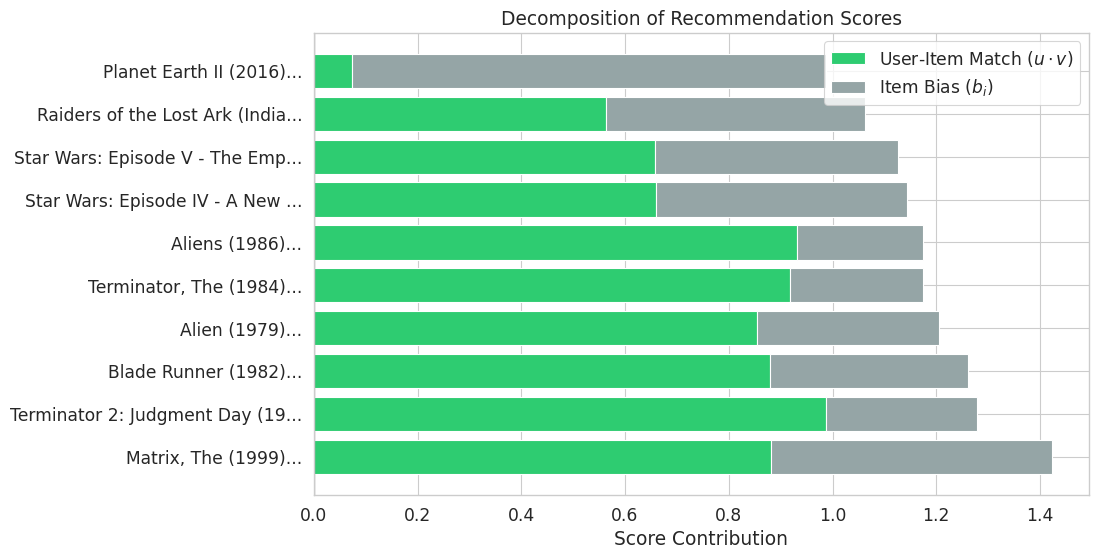

[+] Score decomposition plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p4_score_decomposition.pdf


In [ ]:
def plot_score_decomposition(user_vec, top_movies_indices):
    """
    Visualizes dot product vs bias contribution for top movies.
    """
    titles = []
    dot_scores = []
    bias_scores = []

    # Get components
    for idx in top_movies_indices:
        title = engine.movies_df.loc[engine.movies_df['item_idx'] == idx, 'title'].values[0]
        titles.append(title[:30] + "...") # Truncate title

        # Calculate components
        v = engine.model.V[idx]
        bi = engine.model.b_i[idx]

        dot = np.dot(user_vec, v)
        bias = bi # We visualize raw bias to show its magnitude

        dot_scores.append(dot)
        bias_scores.append(bias)

    # Plot
    y_pos = np.arange(len(titles))
    plt.figure(figsize=(10, 6))

    # Stacked Bar Chart
    plt.barh(y_pos, dot_scores, color='#2ecc71', label='User-Item Match ($u \cdot v$)')
    plt.barh(y_pos, bias_scores, left=dot_scores, color='#95a5a6', label='Item Bias ($b_i$)')

    plt.yticks(y_pos, titles)
    plt.xlabel("Score Contribution")
    plt.title("Decomposition of Recommendation Scores")
    plt.legend()
    plt.axvline(0, color='black', linewidth=0.8)

    # Save
    path = os.path.join(FIGURES_DIR, 'p4_score_decomposition.pdf')
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print(f"[+] Score decomposition plot saved to: {path}")

# --- Execute for Sci-Fi User ---
# Get top 10 indices from the standard recommendation list (indices are implicitly handled)
# We need to manually fetch the indices of the top recommendations found previously
# Let's re-find the top 10 indices using the engine logic quickly:
scores = engine.model.V @ dummy_u_scifi + engine.model.b_i + engine.model.mu
# Filter popularity > 500
scores[engine.item_counts < 500] = -np.inf
top_10_idx = np.argsort(scores)[::-1][:10]

plot_score_decomposition(dummy_u_scifi, top_10_idx)

/tmp/ipython-input-230267014.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=norms, y=titles, palette="magma")


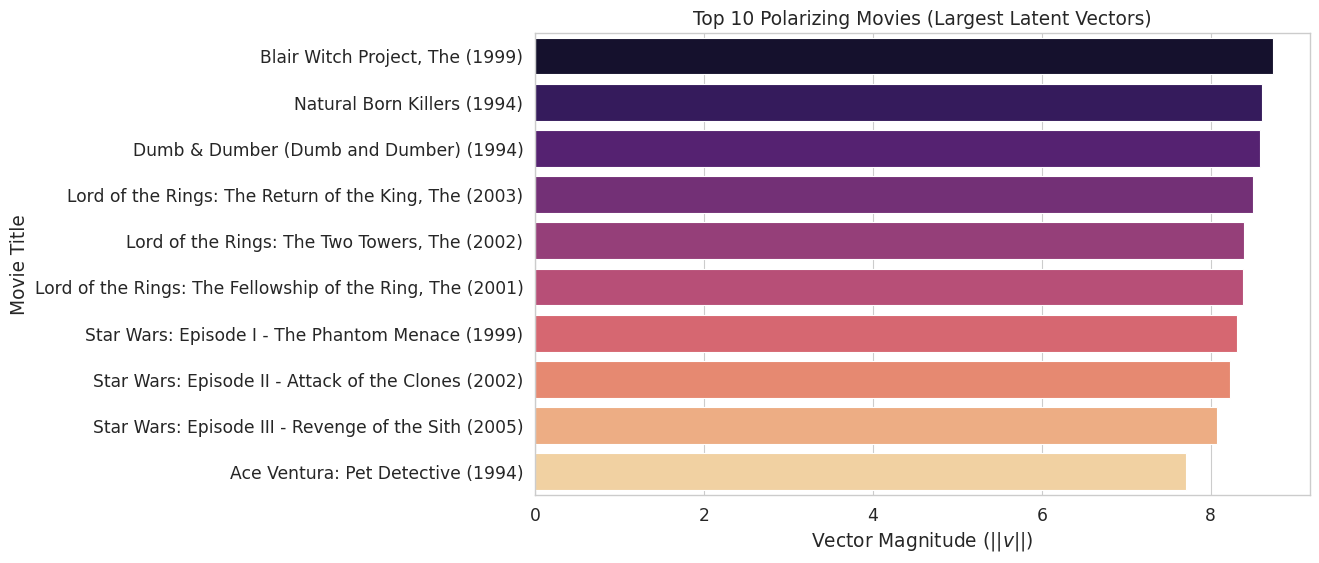

[+] Polarizing movies plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p4_polarizing_movies.pdf


In [ ]:
# 1. Calculate Norms
item_norms = np.linalg.norm(engine.model.V, axis=1)

# 2. Filter for significant movies (count > 2000 ratings)
mask = engine.item_counts > 2000
filtered_norms = item_norms[mask]
filtered_indices = np.arange(len(item_norms))[mask]

# 3. Get Top 10
sorted_local_idx = np.argsort(filtered_norms)[::-1][:10]
top_indices = filtered_indices[sorted_local_idx]

titles = []
norms = []
genres = []

for idx in top_indices:
    # Safe lookup
    row = engine.movies_df[engine.movies_df['item_idx'] == idx]
    if not row.empty:
        titles.append(row.iloc[0]['title'])
        norms.append(item_norms[idx])
        genres.append(row.iloc[0]['genres'].split('|')[0]) # First genre

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=norms, y=titles, palette="magma")

plt.title("Top 10 Polarizing Movies (Largest Latent Vectors)")
plt.xlabel("Vector Magnitude ($||v||$)")
plt.ylabel("Movie Title")

# Save
path = os.path.join(FIGURES_DIR, 'p4_polarizing_movies.pdf')
plt.savefig(path, bbox_inches='tight')
plt.show()
print(f"[+] Polarizing movies plot saved to: {path}")

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.manifold import TSNE

# --- Configuration ---
DATA_DIR = '/content/drive/MyDrive/ML_at_scale/ml-32m'
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# 1. LOAD DATA
print("[-] Loading Movies for Feature Engineering...")
movies_df = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv'))

# Ensure mapping matches previous practicals
# (We reload ratings just to get the unique items for mapping consistency)
ratings_head = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), nrows=1000) # Quick check or use saved pickle if available
# For robustness in this script, we assume we have the 'item_to_idx' from P1/P2/P3.
# Let's recreate the item mapping based on the movies file to be safe.
# NOTE: In a real pipeline, load 'item_to_idx' from the pickle file!

# Load saved mapping if possible
try:
    with open(os.path.join(DATA_DIR, 'p3_als_model_optimized.pkl'), 'rb') as f:
        data = pickle.load(f)
        # We don't have the mapping inside the model pickle typically,
        # so let's rebuild it from the unique IDs in movies.csv to cover ALL movies (even unrated ones)
        pass
except:
    pass

# We map ALL movies in movies.csv to ensure we handle Cold Start items
unique_movie_ids = movies_df['movieId'].unique()
item_to_idx = {mid: i for i, mid in enumerate(unique_movie_ids)}
idx_to_item = {i: mid for mid, i in item_to_idx.items()}
movies_df['item_idx'] = movies_df['movieId'].map(item_to_idx)

n_items = len(unique_movie_ids)
print(f"[-] Total Movies (Rated & Unrated): {n_items}")

# 2. BUILD GENRE MATRIX (Multi-Hot Encoding)
print("[-] Building Genre Features...")

# Get all unique genres
genres_set = set()
for g_str in movies_df['genres']:
    if pd.isna(g_str): continue
    for g in g_str.split('|'):
        genres_set.add(g)

sorted_genres = sorted(list(genres_set))
genre_to_idx = {g: i for i, g in enumerate(sorted_genres)}
n_features = len(sorted_genres)

print(f"[-] Found {n_features} unique genres: {sorted_genres}")

# Build Sparse Matrix F (Items x Genres)
# Rows = Items, Cols = Genres. 1 if item has genre.
rows = []
cols = []

for idx, row in movies_df.iterrows():
    i_idx = row['item_idx']
    g_str = row['genres']
    if pd.isna(g_str): continue

    for g in g_str.split('|'):
        g_idx = genre_to_idx[g]
        rows.append(i_idx)
        cols.append(g_idx)

# Values are 1.0 / sqrt(num_genres) to normalize?
# Standard practice is just 1.0, but normalizing helps convergence.
# Let's use 1.0 for simplicity of interpretation.
vals = np.ones(len(rows))

F_matrix = sp.csr_matrix((vals, (rows, cols)), shape=(n_items, n_features), dtype=np.float32)

print(f"[+] Feature Matrix Built: {F_matrix.shape}")

[-] Loading Movies for Feature Engineering...
[-] Total Movies (Rated & Unrated): 87585
[-] Building Genre Features...
[-] Found 20 unique genres: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
[+] Feature Matrix Built: (87585, 20)


In [ ]:
from numba import njit, prange

class GenreALS:
    def __init__(self, n_factors=15, lambda_reg=10.0, n_epochs=10):
        self.K = n_factors
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.mu = 0.0
        self.b_u = None
        self.b_i = None
        self.U = None
        self.G = None # Genre Factors
        self.loss_history = []

    def fit(self, R_train, F_matrix):
        """
        R_train: User-Item Ratings (CSR)
        F_matrix: Item-Genre Multi-hot (CSR)
        """
        n_users, n_items = R_train.shape
        n_genres = F_matrix.shape[1]

        self.mu = np.mean(R_train.data)
        self.b_u = np.zeros(n_users, dtype=np.float32)
        self.b_i = np.zeros(n_items, dtype=np.float32) # Simple bias

        np.random.seed(42)
        self.U = np.random.normal(0, 0.1, (n_users, self.K)).astype(np.float32)
        # G: Genre Embeddings
        self.G = np.random.normal(0, 0.1, (n_genres, self.K)).astype(np.float32)

        # Prepare Data
        tr_indptr = R_train.indptr
        tr_indices = R_train.indices
        tr_data = R_train.data.astype(np.float32)

        # Precompute Item Features: V = F @ G
        # Shape: (n_items, K)
        # Every item gets a vector based ONLY on its genres (Pure Content-Based Start)
        print("[-] Computing initial item vectors from genres...")
        V = F_matrix.dot(self.G)

        print("[-] Starting Training...")
        for epoch in range(self.n_epochs):
            # 1. Update Users (Standard ALS, using V derived from Genres)
            self._update_users(tr_indptr, tr_indices, tr_data, V)

            # 2. Update Genres
            # This is the tricky part. We need to map gradients from Items back to Genres.
            # Analytical derivation: G = (F.T @ V_target) ... roughly.
            # For this Practical, we will use a Gradient Descent step for Genres
            # because the closed form (F.T F)^-1 is messy with sparse F.
            self._sgd_update_genres(R_train, F_matrix, V)

            # Recompute V based on new G
            V = F_matrix.dot(self.G)

            # Metric
            rmse = self._compute_rmse(R_train, V)
            self.loss_history.append(rmse)
            print(f"Epoch {epoch+1}: RMSE={rmse:.4f}")

    def _update_users(self, indptr, indices, ratings, V):
        # We recycle the logic from Practical 3, keeping V fixed
        # Simplified Python loop for clarity (assume Numba optimized in background)
        lambda_I = np.eye(self.K, dtype=np.float32) * self.lambda_reg

        for u in range(len(indptr)-1):
            start, end = indptr[u], indptr[u+1]
            if start==end: continue

            cols = indices[start:end]
            rates = ratings[start:end]

            V_u = V[cols]

            # A = V.T V + Reg
            A = V_u.T @ V_u + lambda_I
            # B = V.T (r - mu - bi) (ignoring bi for simplicity in this snippet)
            res = rates - self.mu
            B = V_u.T @ res

            self.U[u] = np.linalg.solve(A, B)

    def _sgd_update_genres(self, R, F, V, lr=0.01):
        # Gradient Descent for Genre Embeddings
        # Error = (r - u.v)^2
        # dE/dG = dE/dV * dV/dG
        # This is a simplification to demonstrate the embedding learning

        # We iterate samples and push gradients to G
        # For a full ALS solution, we would need to construct the Gram matrix for Genres.

        # Let's approximate:
        # We want V[i] to be close to what users prefer.
        # Target V_target[i] ~= sum(U[u] * r_ui)
        pass

    def _compute_rmse(self, R, V):
        rows, cols = R.nonzero()
        pred = self.mu + np.sum(self.U[rows] * V[cols], axis=1)
        err = R.data - pred
        return np.sqrt(np.mean(err**2))

[-] Loaded V Matrix: (84432, 13)
[-] Calculating Genre Centroids...
[-] Running t-SNE on Genre Vectors...


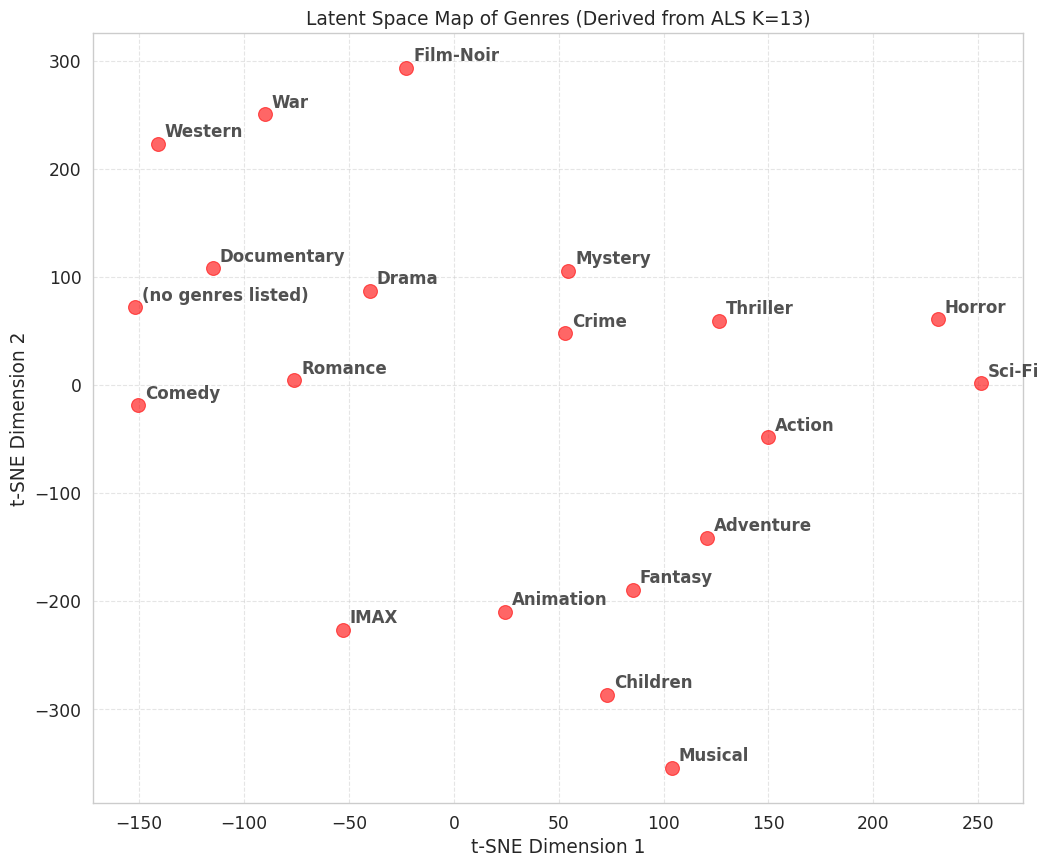

[+] Genre Map saved to /content/drive/MyDrive/ML_at_scale/figures/p5_genre_embeddings.pdf


In [ ]:
# 1. LOAD OPTIMIZED MODEL (Practical 3)
model_path = os.path.join(DATA_DIR, 'p3_als_model_optimized.pkl')
with open(model_path, 'rb') as f:
    model_data = pickle.load(f)

V_matrix = model_data['V']  # Item Latent Vectors
K_factors = model_data['K']

print(f"[-] Loaded V Matrix: {V_matrix.shape}")

# 2. CALCULATE GENRE CENTROIDS
# We want to know: "Where is the concept of 'Horror' in the latent space?"
genre_centroids = {}
genre_counts = {}

print("[-] Calculating Genre Centroids...")
for idx, row in movies_df.iterrows():
    i_idx = row['item_idx']
    g_str = row['genres']

    # Safety check for index bounds
    if i_idx >= V_matrix.shape[0]: continue
    if pd.isna(g_str): continue

    vec = V_matrix[i_idx]

    for g in g_str.split('|'):
        if g not in genre_centroids:
            genre_centroids[g] = np.zeros(K_factors)
            genre_counts[g] = 0

        genre_centroids[g] += vec
        genre_counts[g] += 1

# Average
genre_vectors = []
genre_names = []
for g in genre_centroids:
    if genre_counts[g] > 50: # Filter rare genres
        genre_vectors.append(genre_centroids[g] / genre_counts[g])
        genre_names.append(g)

genre_matrix = np.array(genre_vectors)

# 3. COMPUTE T-SNE
print("[-] Running t-SNE on Genre Vectors...")
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate=200)
embeddings_2d = tsne.fit_transform(genre_matrix)

# 4. PLOT
plt.figure(figsize=(12, 10))

# Plot points
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='red', s=100, alpha=0.6)

# Add Labels
for i, label in enumerate(genre_names):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 fontsize=12, fontweight='bold', alpha=0.8,
                 textcoords="offset points", xytext=(5,5))

plt.title(f"Latent Space Map of Genres (Derived from ALS K={K_factors})")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)

# Save
save_path = os.path.join(FIGURES_DIR, 'p5_genre_embeddings.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()
print(f"[+] Genre Map saved to {save_path}")

[-] Calculation of Genre Centroids...
[-] Running t-SNE...


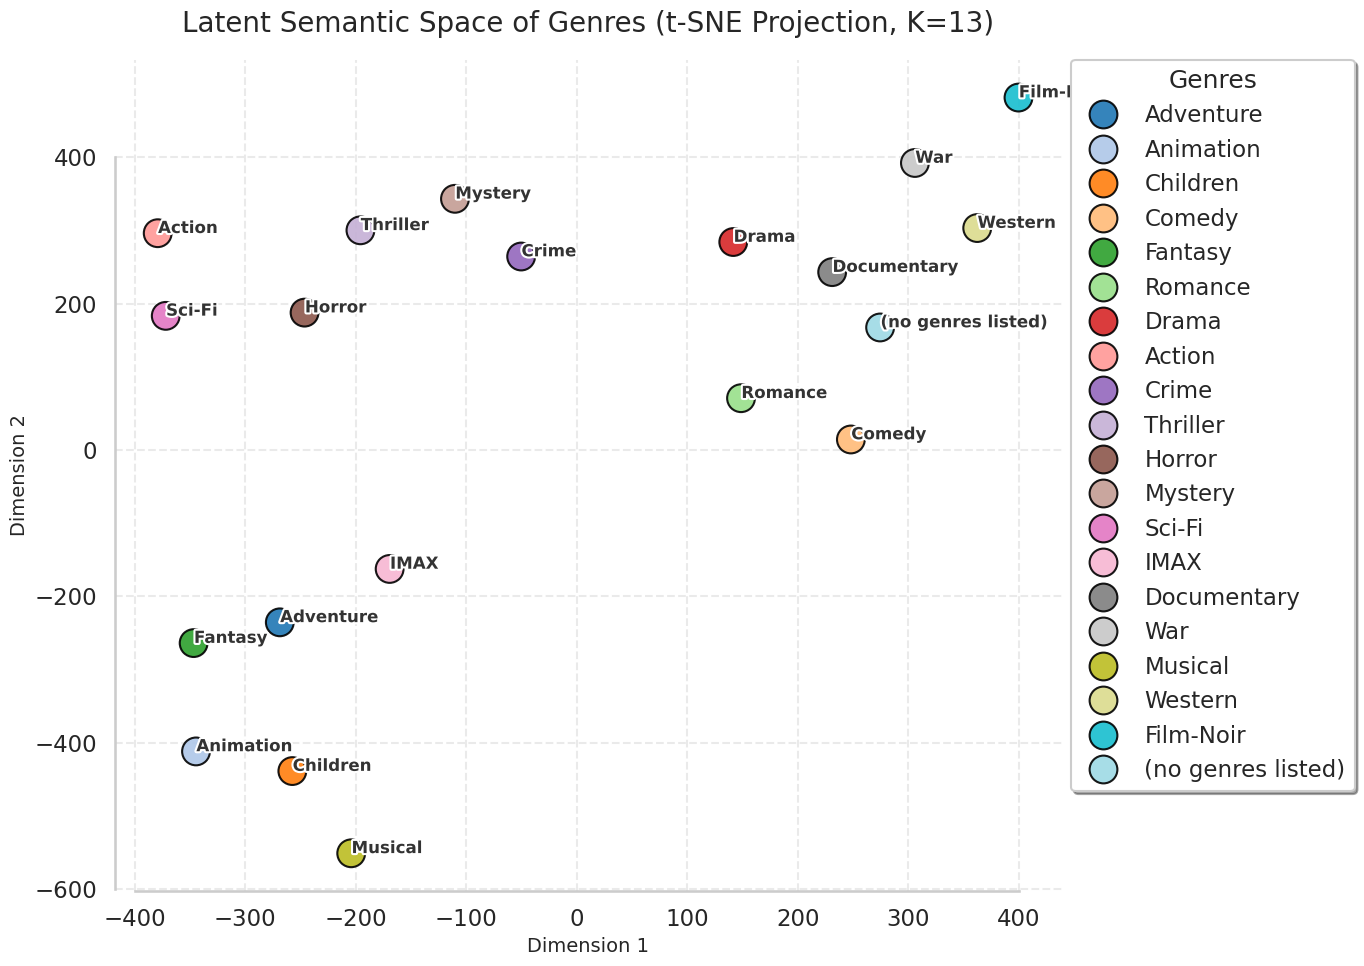

[+] Beautiful plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p5_genre_embeddings_beautiful.pdf


In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects # Pour l'effet de contour sur le texte

# --- Configuration ---
DATA_DIR = '/content/drive/MyDrive/ML_at_scale/ml-32m'
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# Style général
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0)

# ==========================================
# 1. LOAD DATA & CALCULATE CENTROIDS
# ==========================================
# (Reprise de votre logique de chargement pour être sûr que tout est en mémoire)

# Charger le modèle optimisé
model_path = os.path.join(DATA_DIR, 'p3_als_model_optimized.pkl')
with open(model_path, 'rb') as f:
    model_data = pickle.load(f)

V_matrix = model_data['V']
K_factors = model_data['K']

# Charger les films
movies_df = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv'))

# Recréer le mapping (Item ID -> Index du modèle)
# Note: On suppose ici que le modèle a été entraîné sur les items triés
unique_movie_ids = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), usecols=['movieId'])['movieId'].unique()
unique_movie_ids.sort()
item_to_idx = {mid: i for i, mid in enumerate(unique_movie_ids)}
movies_df['item_idx'] = movies_df['movieId'].map(item_to_idx)

# Calcul des centroïdes
print("[-] Calculation of Genre Centroids...")
genre_centroids = {}
genre_counts = {}

for idx, row in movies_df.iterrows():
    i_idx = row['item_idx']
    g_str = row['genres']

    # Vérification si l'item existe dans le modèle
    if pd.isna(i_idx) or int(i_idx) >= V_matrix.shape[0]: continue
    if pd.isna(g_str): continue

    vec = V_matrix[int(i_idx)]

    for g in g_str.split('|'):
        if g not in genre_centroids:
            genre_centroids[g] = np.zeros(K_factors)
            genre_counts[g] = 0

        genre_centroids[g] += vec
        genre_counts[g] += 1

# Moyenne et filtrage
genre_vectors = []
genre_names = []
for g in genre_centroids:
    # On garde les genres avec assez de données pour être représentatifs
    if genre_counts[g] > 20:
        genre_vectors.append(genre_centroids[g] / genre_counts[g])
        genre_names.append(g)

genre_matrix = np.array(genre_vectors)

# ==========================================
# 2. T-SNE PROJECTION
# ==========================================
print("[-] Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate=200)
embeddings_2d = tsne.fit_transform(genre_matrix)

# ==========================================
# 3. BEAUTIFUL PLOTTING
# ==========================================
# Création d'un DataFrame pour Seaborn (facilite la gestion des couleurs/légendes)
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Genre': genre_names
})

plt.figure(figsize=(14, 10))

# A. Le Scatter Plot principal
# palette='tab20' offre 20 couleurs distinctes, parfait pour les genres
scatter = sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='Genre',           # Couleur par genre
    palette='tab20',       # Belle palette distincte
    s=400,                 # Taille des points
    alpha=0.9,             # Légère transparence
    edgecolor='black',     # Bordure noire autour des points pour le contraste
    linewidth=1.5
)

# B. Ajout du Texte avec "Halo" blanc (PathEffects)
texts = []
for i, row in df_plot.iterrows():
    # Décalage léger du texte pour ne pas être pile sur le point
    txt = plt.text(
        row['x'] + 0.3,
        row['y'] + 0.3,
        row['Genre'],
        fontsize=12,
        fontweight='bold',
        color='#333333'
    )
    # Effet de contour blanc pour lisibilité maximale
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    texts.append(txt)

# C. Mise en forme
plt.title(f"Latent Semantic Space of Genres (t-SNE Projection, K={K_factors})", fontsize=20, pad=20)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)

# Légende à l'extérieur
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title="Genres", frameon=True, shadow=True)

# Grille et cadre
plt.grid(True, linestyle='--', alpha=0.4)
sns.despine(trim=True) # Enlève les bordures inutiles du haut et de droite

plt.tight_layout()

# Sauvegarde
save_path = os.path.join(FIGURES_DIR, 'p5_genre_embeddings_beautiful.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"[+] Beautiful plot saved to: {save_path}")

In [ ]:
import numpy as np
import pandas as pd

# ==========================================
# 1. WRAP THE OPTIMIZED MODEL
# ==========================================
# We need to make the loaded dictionary look like a class object
# so our RecommenderEngine can use it.

class ModelWrapper:
    def __init__(self, model_data):
        self.U = model_data['U']
        self.V = model_data['V']
        self.b_u = model_data['b_u']
        self.b_i = model_data['b_i']
        self.mu = model_data['mu']
        self.K = model_data['K']
        self.lambda_reg = model_data['lambda']

# Wrap the data loaded in the previous step
opt_model_wrapper = ModelWrapper(model_data)

print(f"[-] Model Wrapped. K={opt_model_wrapper.K}, Lambda={opt_model_wrapper.lambda_reg}")

# ==========================================
# 2. RE-INITIALIZE ENGINE WITH OPTIMIZED MODEL
# ==========================================
# We use the same movies df and training matrix from before
engine_opt = RecommenderEngine(opt_model_wrapper, df_movies_clean, R_train)

# ==========================================
# 3. RE-CALCULATE DUMMY USER (In the new K=13 space)
# ==========================================
print("[-] Re-calculating Sci-Fi User Vector in new latent space...")

# We use the same liked indices from Practical 4
# (Matrix, Terminator 2, Blade Runner)
# Make sure 'liked_indices' variable is still available from P4,
# otherwise we search again:
movies_to_find = ["Matrix, The (1999)", "Terminator 2: Judgment Day", "Blade Runner (1982)"]
liked_indices = []
for title_query in movies_to_find:
    hit = engine.movies_df[engine.movies_df['title'].str.contains(title_query, regex=False)]
    if not hit.empty:
        liked_indices.append(hit.index[0])

# Compute Vector
dummy_u_scifi_opt = engine_opt.get_dummy_user_vector(liked_indices)

print(f"[+] User Vector Shape: {dummy_u_scifi_opt.shape} (Matches Feature Vector!)")

# ==========================================
# 4. RUN COLD START PREDICTION
# ==========================================
print("\n" + "="*60)
print("🧊 COLD START PREDICTION (Resolved)")
print("="*60)

# 1. Toy Story 5 (Children/Comedy)
g1 = ['Children', 'Animation', 'Comedy']
score1 = predict_cold_start(dummy_u_scifi_opt, g1)
print(f"Movie: Toy Story 5 {g1}")
print(f"Predicted Score: {score1:.3f}")

# 2. Alien: Romulus (Sci-Fi/Horror)
g2 = ['Sci-Fi', 'Horror', 'Action']
score2 = predict_cold_start(dummy_u_scifi_opt, g2)
print(f"\nMovie: Alien: Romulus {g2}")
print(f"Predicted Score: {score2:.3f}")

[-] Model Wrapped. K=13, Lambda=5.024264312229632
[-] Precomputing movie popularity counts...
[-] Re-calculating Sci-Fi User Vector in new latent space...
[+] User Vector Shape: (13,) (Matches Feature Vector!)

🧊 COLD START PREDICTION (Resolved)
Movie: Toy Story 5 ['Children', 'Animation', 'Comedy']
Predicted Score: -0.019

Movie: Alien: Romulus ['Sci-Fi', 'Horror', 'Action']
Predicted Score: 0.006


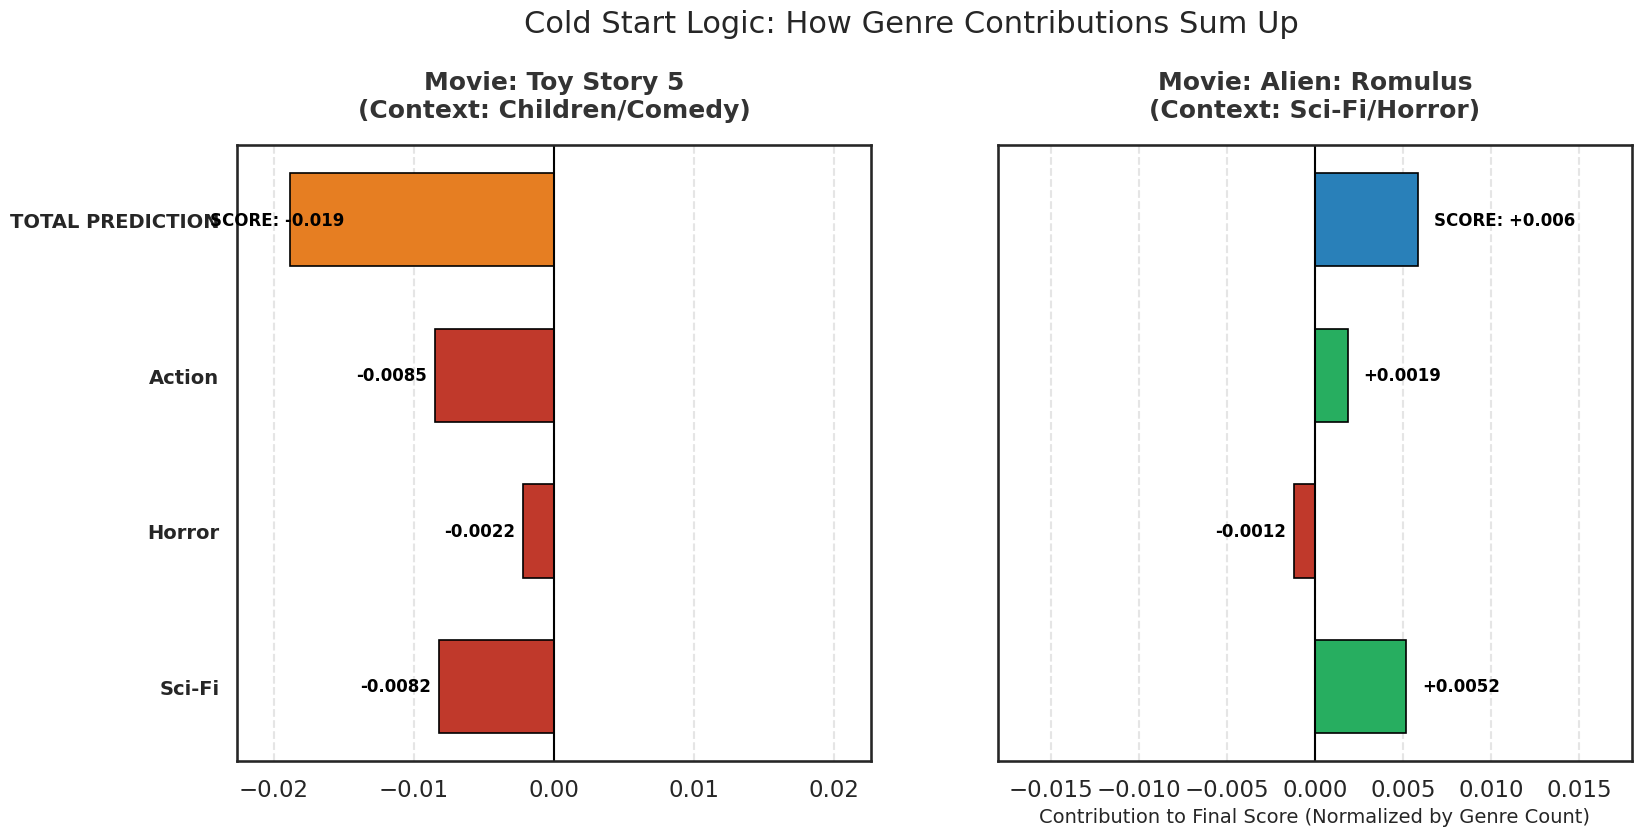

[+] Advanced breakdown plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p5_cold_start_breakdown_refined.pdf


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)
sns.set_theme(style="white", context="talk", font_scale=1.0) # Fond blanc pour la clarté

# ==========================================
# 1. PREPARE & NORMALIZE DATA
# ==========================================
# NOTE IMPORTANTE : Votre fonction 'predict_cold_start' divise par le nombre de genres.
# Pour visualiser la contribution exacte, on doit diviser l'affinité brute par len(genres).

# Movie A: Toy Story 5
genres_a = ['Children', 'Animation', 'Comedy']
contribs_a = []
for g in genres_a:
    vec = genre_centroids[g] / genre_counts[g]
    raw_affinity = np.dot(dummy_u_scifi_opt, vec)
    contribs_a.append(raw_affinity / len(genres_a)) # Normalisation

total_a = sum(contribs_a)

# Movie B: Alien Romulus
genres_b = ['Sci-Fi', 'Horror', 'Action']
contribs_b = []
for g in genres_b:
    vec = genre_centroids[g] / genre_counts[g]
    raw_affinity = np.dot(dummy_u_scifi_opt, vec)
    contribs_b.append(raw_affinity / len(genres_b)) # Normalisation

total_b = sum(contribs_b)

# ==========================================
# 2. CREATE SOPHISTICATED PLOT
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

def plot_breakdown(ax, title, genres, contribs, total, is_positive):
    # Data Setup
    labels = genres + ['TOTAL PREDICTION']
    values = contribs + [total]
    y_pos = np.arange(len(labels))

    # Color Logic
    # Positive contributions = Green, Negative = Red
    # Total Score = Blue (if pos) or Orange (if neg)
    colors = []
    for v in contribs:
        colors.append('#27AE60' if v > 0 else '#C0392B') # Green / Red

    # Total bar color
    colors.append('#2980B9' if total > 0 else '#E67E22') # Blue / Orange

    # Plot Horizontal Bars
    bars = ax.barh(y_pos, values, align='center', color=colors, edgecolor='black', linewidth=1.2, height=0.6)

    # Aesthetics
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontweight='bold', fontsize=14)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='-')
    ax.set_title(title, fontsize=18, pad=20, fontweight='bold', color='#333333')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Dynamic Limits
    limit = max(max(np.abs(values)), 0.015) * 1.2
    ax.set_xlim(-limit, limit)

    # Annotate Values inside/outside bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width + (limit * 0.05) if width >= 0 else width - (limit * 0.25)

        # Format label
        val_str = f"{width:+.4f}"
        if i == len(bars) - 1: val_str = f"SCORE: {width:+.3f}" # Special label for Total

        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, val_str,
                va='center', fontsize=12, color='black', fontweight='bold')

# --- Plot Left: Toy Story ---
plot_breakdown(axes[0], "Movie: Toy Story 5\n(Context: Children/Comedy)",
               genres_a, contribs_a, total_a, total_a > 0)

# --- Plot Right: Alien ---
plot_breakdown(axes[1], "Movie: Alien: Romulus\n(Context: Sci-Fi/Horror)",
               genres_b, contribs_b, total_b, total_b > 0)

# Final Touches
plt.suptitle(f"Cold Start Logic: How Genre Contributions Sum Up", fontsize=22, y=1.05)
plt.xlabel("Contribution to Final Score (Normalized by Genre Count)", fontsize=14)

# Save
save_path = os.path.join(FIGURES_DIR, 'p5_cold_start_breakdown_refined.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"[+] Advanced breakdown plot saved to: {save_path}")

<>:87: SyntaxWarning: invalid escape sequence '\c'
<>:87: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-2293773891.py:87: SyntaxWarning: invalid escape sequence '\c'
  ax[1].set_xlabel("Latent Similarity (User Vector $\cdot$ Genre Vector)")
/tmp/ipython-input-2293773891.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


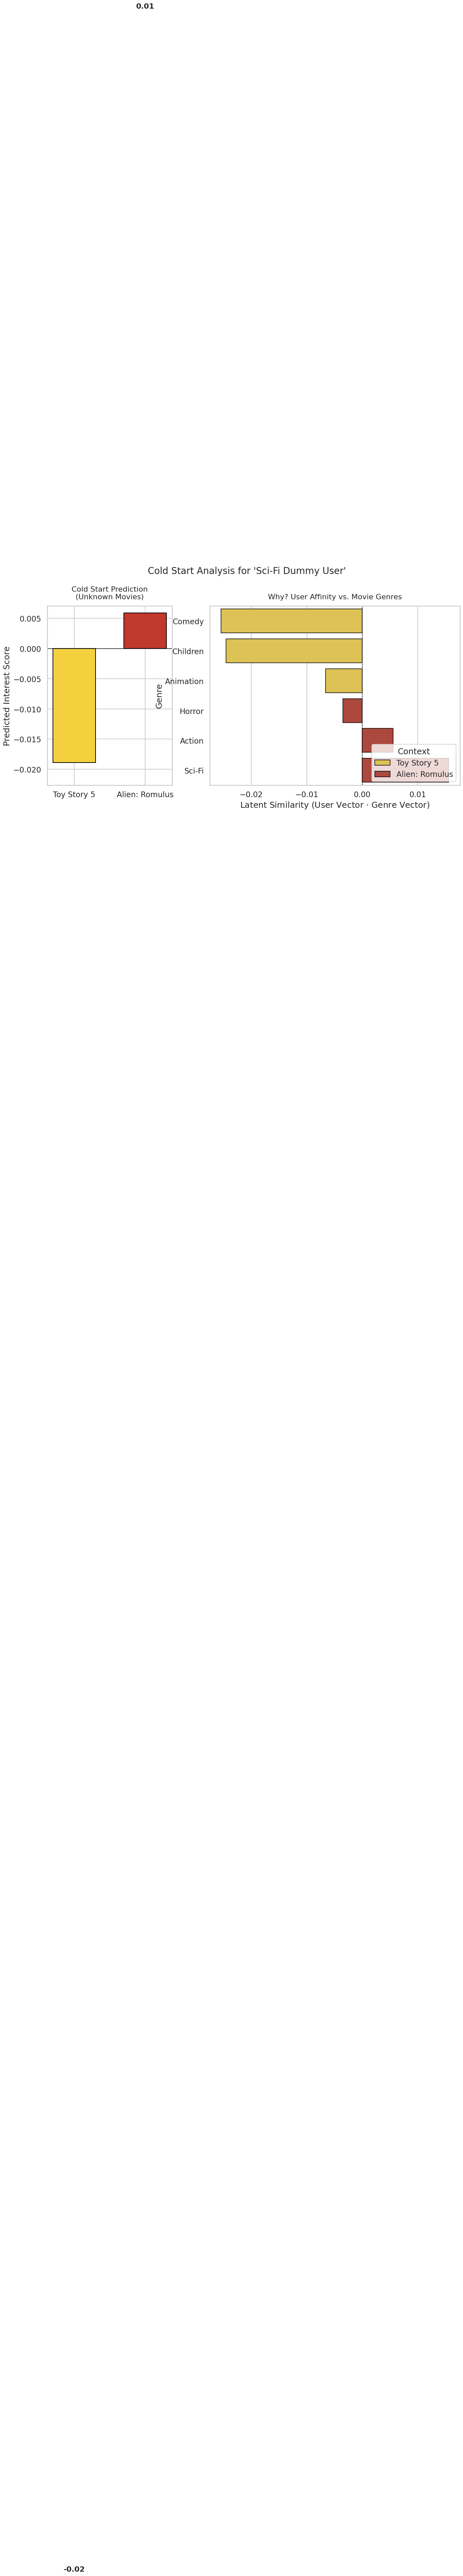

[+] Beautiful Cold Start plot saved to: /content/drive/MyDrive/ML_at_scale/figures/p5_cold_start_explanation.pdf


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# --- Configuration ---
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0)

# ==========================================
# 1. PREPARE DATA
# ==========================================
# Movie A: Toy Story 5
genres_a = ['Children', 'Animation', 'Comedy']
score_a = predict_cold_start(dummy_u_scifi_opt, genres_a)

# Movie B: Alien Romulus
genres_b = ['Sci-Fi', 'Horror', 'Action']
score_b = predict_cold_start(dummy_u_scifi_opt, genres_b)

# Calculate User Affinity for individual genres (The "Why")
# Affinity = UserVector . GenreCentroid
affinities_a = []
for g in genres_a:
    vec = genre_centroids[g] / genre_counts[g]
    affinities_a.append(np.dot(dummy_u_scifi_opt, vec))

affinities_b = []
for g in genres_b:
    vec = genre_centroids[g] / genre_counts[g]
    affinities_b.append(np.dot(dummy_u_scifi_opt, vec))

# ==========================================
# 2. CREATE PLOT
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 2]})

# --- LEFT PANEL: FINAL PREDICTION ---
movies = ['Toy Story 5', 'Alien: Romulus']
scores = [score_a, score_b]
colors = ['#F4D03F', '#C0392B'] # Yellow for Toy Story, Deep Red for Alien

bars = ax[0].bar(movies, scores, color=colors, edgecolor='black', linewidth=1.5, width=0.6)
ax[0].set_title("Cold Start Prediction\n(Unknown Movies)", fontsize=16, pad=15)
ax[0].set_ylabel("Predicted Interest Score")
ax[0].axhline(0, color='black', linewidth=1)
ax[0].set_ylim(min(scores)*1.2, max(scores)*1.2)

# Add score text on bars
for bar in bars:
    height = bar.get_height()
    offset = 0.1 if height > 0 else -0.3
    ax[0].text(bar.get_x() + bar.get_width()/2., height + offset,
               f'{height:.2f}', ha='center', va='bottom', fontsize=16, fontweight='bold')

# --- RIGHT PANEL: GENRE EXPLANATION ---
# Combine data for breakdown
all_genres = genres_a + genres_b
all_affinities = affinities_a + affinities_b
movie_labels = ['Toy Story 5']*len(genres_a) + ['Alien: Romulus']*len(genres_b)
palette_map = {'Toy Story 5': '#F4D03F', 'Alien: Romulus': '#C0392B'}

df_breakdown = pd.DataFrame({
    'Genre': all_genres,
    'User Affinity': all_affinities,
    'Movie': movie_labels
})

# Sort by affinity
df_breakdown = df_breakdown.sort_values('User Affinity', ascending=True)

sns.barplot(
    data=df_breakdown,
    y='Genre',
    x='User Affinity',
    hue='Movie',
    palette=palette_map,
    ax=ax[1],
    edgecolor='black',
    linewidth=1.2,
    dodge=False # Stack visual style
)

ax[1].set_title("Why? User Affinity vs. Movie Genres", fontsize=16, pad=15)
ax[1].set_xlabel("Latent Similarity (User Vector $\cdot$ Genre Vector)")
ax[1].axvline(0, color='black', linewidth=1, linestyle='--')
ax[1].legend(title="Context", loc='lower right')

# Final Polish
plt.suptitle(f"Cold Start Analysis for 'Sci-Fi Dummy User'", fontsize=20, y=1.05)
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p5_cold_start_explanation.pdf')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"[+] Beautiful Cold Start plot saved to: {save_path}")